In [3]:
%matplotlib widget
%reload_ext autoreload
from Observation import *
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1 import make_axes_locatable
import re
import glob, os
from astropy import units as u
sheet_id = "1Ox0uxEm2TfgzYA6ivkTpU4xrmN5vO5kmnUPdCSt73uU"
sheet_name = "instruments.csv"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
try:
    instruments = Table.from_pandas(pd.read_csv(url))
except Exception:
    instruments = Table.read("Instruments.csv")
instruments = instruments[instruments.colnames]
instruments_dict ={ name:{key:float(val) for key, val in zip(instruments["Charact."][:],instruments[name][:])} for name in instruments.colnames[3:]}




def dark_plateau(T=-80,a=0.23362821,plateau=0.44384484):
    T = T+273.15
    E = 1.1557 - (7.021*1e-4*T**2)/(1108+T)
    k = 8.62e-5
    return 2.55*1e15*a*3600*0.0013**2*T**(3/2)*np.exp(-E/(2*k*T))+plateau



from matplotlib.colors import LogNorm
# from pyds9plugin.DS9Utils import PlotFit1D

import math as mt
import cmocean

def mostFrequent(arr):
    n=len(arr)
    # Insert all elements in Hash.
    Hash = dict()
    for i in range(n):
        if arr[i] in Hash.keys():
            Hash[arr[i]] += 1
        else:
            Hash[arr[i]] = 1
 
    # find the max frequency
    max_count = 0
    res = -1
    for i in Hash:
        if (max_count < Hash[i]):
            res = i
            max_count = Hash[i]
         
    return res

gaus = lambda x, a, xo, sigma, offset: a ** 2 * np.exp(-np.square((x - xo) / sigma) / 2)+ offset

# n1,n=100,500
n2,n1=100,500



class ExposureTimeCalulator(widgets.HBox):
    @initializer
    def __init__(self, instrument="FIREBall-2 2023",x_axis='exposure_time', time_max = 1005, **kwargs):#, Atmosphere=0.5, Throughput=0.13*0.9, follow_temp=False, acquisition_time=1, Sky=4, Signal=24, EM_gain=1400,RN=109,CIC_charge=0.005, Dard_current=0.08,readout_time=1.5,counting_mode=False,smearing=0.7,extra_background=0,temperature=-100,PSF_RMS_mask=2.5,PSF_RMS_det = 3.5,QE=0.45,cosmic_ray_loss_per_sec=0.005,
        """
        Generate an ETC app containing multiple widghet that allow to change the ETC parameters
        as well as plotting the result (e- and noise budget, limiting flux, SNR) in terms of the different parameters.
        """
        super().__init__()
        args, _, _, locals_ = inspect.getargvalues(inspect.currentframe())


        for i in range(len(instruments)):
            setattr(self, instruments["Charact."][i], float(instruments[instrument][i]) )


        exposure_time=np.logspace(0,np.log10(time_max))

        self.output = widgets.Output()
        time=exposure_time
        self.time =  float(instruments[instrument][instruments["Charact."]=="exposure_time"][0])
        i = np.argmin(abs(self.time - exposure_time))
        self.arg=i
        self.new = Observation(instrument=instrument,smearing=self.smearing,counting_mode=False,exposure_time=exposure_time,Sky=self.Sky,acquisition_time=self.acquisition_time,Signal=self.Signal,EM_gain=self.EM_gain,RN=self.RN, CIC_charge=self.CIC_charge, Dard_current=self.Dard_current,PSF_RMS_mask=self.PSF_RMS_mask,PSF_RMS_det=self.PSF_RMS_det,QE=self.QE, extra_background=self.extra_background,
            Collecting_area=self.Collecting_area, pixel_scale=self.pixel_scale, Throughput=self.Throughput, Spectral_resolution=self.Spectral_resolution, Slitwidth=self.Slitwidth, dispersion=self.dispersion,
            PSF_source=self.PSF_source,Line_width=self.Line_width,wavelength=self.wavelength,Δλ=self.Δλ,Δx=self.Δx, Atmosphere=self.Atmosphere, pixel_size=self.pixel_size,cosmic_ray_loss_per_sec=self.cosmic_ray_loss_per_sec,readout_time=self.readout_time, Slitlength=self.Slitlength)

        # Nominal = Observation(instrument=instrument, Atmosphere=Atmosphere, Throughput=Throughput, exposure_time=exposure_time,counting_mode=counting_mode, Signal=Signal, EM_gain=EM_gain, RN=RN, CIC_charge=CIC_charge, Dard_current=Dard_current, Sky=10**Sky, readout_time=readout_time, acquisition_time = acquisition_time,extra_background=self.extra_background,smearing=smearing,i=i,temperature=temperature,PSF_RMS_mask=PSF_RMS_mask,PSF_RMS_det=PSF_RMS_det,QE=QE,cosmic_ray_loss_per_sec=cosmic_ray_loss_per_sec, **kwargs)#,cosmic_ray_loss=0.25)
        # self.new = Observation(instrument=instrument, Atmosphere=self.Atmosphere, Throughput=self.Throughput, exposure_time=exposure_time,counting_mode=False, Signal=self.Signal, EM_gain=self.EM_gain, RN=self.RN, CIC_charge=self.CIC_charge, Dard_current=self.Dard_current, Sky=self.Sky, readout_time=self.readout_time, acquisition_time = self.acquisition_time,extra_background=self.extra_background,smearing=self.smearing,i=i,temperature=-100,PSF_RMS_mask=self.PSF_RMS_mask,PSF_RMS_det=self.PSF_RMS_det,QE=self.QE,cosmic_ray_loss_per_sec=self.cosmic_ray_loss_per_sec, **kwargs)#,cosmic_ray_loss=0.25)

        self.x = exposure_time
        
        

        style={}
        width = '400px'
        width = '500px'
        small = '247px'
        small = '230px'
        psmall = '186px'
        vsmall = '147px'
        # ALL THE DIFFERENT VARIATION WITH TEMPERATURE
        self.smearing_poly = np.poly1d([-0.0306087, -2.2226087])#np.poly1d([-0.0453913, -3.5573913])
        # self.dark_poly = np.poly1d([2.13640462e-05, 7.83596239e-03, 9.57682651e-01, 3.86154296e+01])#with plateau
        # self.dark_poly = np.poly1d([0.07127906, 6.83562573]) #without plateau# does to low because only calibrated down to -100 but then it kinda saturated. maybe because of CIC?
        self.dark_poly = dark_plateau
        # self.CIC_poly = np.poly1d([1.57925408e-05, 2.80396270e-03, 1.34276224e-01]) #without plateau# does to low because only calibrated down to -100 but then it kinda saturated. maybe because of CIC?


        # self.other_options =  ['exposure_time','acquisition_time',"Signal","RN","Dard_current" ,'Sky',"readout_time","PSF_RMS_det","QE","cosmic_ray_loss_per_sec","Throughput","Atmosphere","lambda_stack","PSF_source",'Collecting_area',"Δx","Δλ"]#[:-3]
        self.other_options =  [
                               "------DECTECTOR PERFORMANCE","QE","RN","Dard_current" ,"cosmic_ray_loss_per_sec", #,"pixel_size"
                               "-------------OBSERVED SOURCE","Signal",'Sky',"PSF_source","Line_width",
                               "--------OBSERVATION STRATEGY", "Atmosphere",'exposure_time','acquisition_time',"readout_time","lambda_stack","Δx","Δλ",  "wavelength",
                               "-----------INSTRUMENT DESIGN",'Collecting_area',"pixel_scale","Throughput","PSF_RMS_mask","PSF_RMS_det",
                               "---------SPECTROGRAPH DESIGN","Spectral_resolution","Slitwidth","dispersion",
        # "---FIREBall specific---",
        ]#[:-3]
        self.fb_options_no_temp = self.other_options + ["----------AMPLIFIED DECTECTOR","EM_gain","CIC_charge","smearing","extra_background"]
        self.fb_options = self.fb_options_no_temp + ["temperature"]

        self.instrument = widgets.Dropdown(options=instruments.colnames[3:],value=instrument,description="<a href=https://docs.google.com/spreadsheets/d/1Ox0uxEm2TfgzYA6ivkTpU4xrmN5vO5kmnUPdCSt73uU/edit#gid=2066284077>Instrument</a>", layout=Layout(width=small),description_tooltip="Instrument characteristics")
        self.ylog = widgets.Checkbox(value=False,description='ylog',disabled=False, layout=Layout(width='147px'),description_tooltip="Use this check box to use a log scale for the y axis")
        self.xlog = widgets.Checkbox(value=True,description='xlog',disabled=False, layout=Layout(width='147px'),description_tooltip="Use this check box to use a log scale for the x axis")
        # self.nax0.set_yscale("log")

       
        self.Signal = widgets.FloatLogSlider(min=-19, max=-13 ,value=self.Signal,description='Flux', layout=Layout(width=width),description_tooltip="Flux of the diffuse source in ergs/cm2/s/arcsec2/Å.")
        self.acquisition_time = widgets.FloatSlider( min=0.1, max=10,value=self.acquisition_time, layout=Layout(width=width),description='Taq (h)',description_tooltip="Total acquisition time [hours]")
        # print(time_max,self.readout_time,self.time)
        self.exposure = widgets.FloatRangeSlider( min=0, max=time_max,value=(self.readout_time,self.time),style = style, layout=Layout(width=width),description='Rd/Exp time',step=0.1,readout_format='.0f',description_tooltip="Readout time and exposure time [seconds]")

        self.fwhm = widgets.FloatRangeSlider( min=0.1, max=6,value=(self.PSF_RMS_mask,self.PSF_RMS_det),style = style, layout=Layout(width=width),description='Mask/det σ',step=0.1,readout_format='.1f',todescription_tooltipoltip="Spatial resolution in arcseconds respectively at the mask and detector level. To be multiplied by 2.35 to have the FWHM.")
        # self.fwhm = widgets.FloatLogRangeSlider( min=1, max=4,value=(1,2),style = style, layout=Layout(width=width),description='Mask/det σ',todescription_tooltipoltip="Spatial resolution in arcseconds respectively at the mask and detector level. To be multiplied by 2.35 to have the FWHM.")
        # self.Sky = widgets.FloatLogSlider( min=0, max=7,value=self.Sky,base=10, style =style, layout=Layout(width=width),description='Sky (CU)',description_tooltip="Level of sky background illumination in Continuum units (CU = 1 ph/cm$^2$/s/sr/Å = 1 LU/Å) ")#5.57e-18
        self.Sky = widgets.FloatLogSlider( min=-19, max=-15,value=self.Sky,base=10, style =style, layout=Layout(width=width),description='Sky',description_tooltip="Level of sky background illumination (zodiacal and galactic) in ergs/cm2/s/arcsec2/Å ")#5.57e-18
        self.RN = widgets.IntSlider( min=0.01, max=120,value=self.RN, style = style, step=1, layout=Layout(width=width),description='Read noise',description_tooltip="Detector readout noise in electrons/pixel")
        self.QE = widgets.FloatSlider( min=0.01, max=1,value=self.QE,style = style, layout=Layout(width=width),description='QE',step=0.01,readout_format='.2f',description_tooltip="Detector quantum efficiency")
        self.Dard_current = widgets.FloatSlider( min=0, max=50,value=self.Dard_current, style = style, layout=Layout(width=width),description='Dard current',step=0.0011,readout_format='.2f',description_tooltip="Detector dark current [e-/pix/hour]")

        self.extra_background = widgets.FloatSlider( min=0, max=20,value=self.extra_background,style = style, layout=Layout(width=width),description='Extra bckgnd',step=0.2,readout_format='.1f',description_tooltip="Additional background on the detector [e-/pix/hour]")
        self.EM_gain = widgets.IntSlider( min=1, max=3500,value=self.EM_gain, style = style, layout=Layout(width=width),description='EM gain',description_tooltip="EMCCD amplification gain in e-/e-")
        self.CIC_charge = widgets.FloatSlider( min=0, max=0.07,value=self.CIC_charge,style = style, layout=Layout(width=width),description='CIC charge',step=0.001,readout_format='.3f',description_tooltip="EMCCD spurious charges due to amplification in electrons [e-/pix]")
        self.follow_temp = widgets.Checkbox(value=False,description='Temp',disabled=False, layout=Layout(width=vsmall),description_tooltip="Check this box to force charge transfer efficiency and dark current levels to be fixed by the temperature widget. Interesting feature to optimize EMCCD temperature.")
        self.counting_mode = widgets.Checkbox(value=False,description='γ-Threshold',disabled=False, layout=Layout(width=psmall),description_tooltip="Check this box to apply thresholding photon counting processing. The efficiency of this process is determined by the gain, read noise, smearing, flux.")
        self.temperature = widgets.FloatSlider( min=-120, max=-85,value=-115, style = style,description=r'Temp (C)',step=0.1, layout=Layout(width=width),description_tooltip="EMCCD's Temperature in Celcius degrees: determines its charge transfer efficiency and dark current rate.")        
        self.smearing = widgets.FloatSlider( min=0, max=self.smearing_poly(-120),value=self.smearing, layout=Layout(width=width),description='Smearing',step=0.01,description_tooltip="Smearing length of the EMCCD (exponential length in pixels). This length, representing the charge transfer efficiency is fixed by the temperature when the Temp checkbox is checked.")   
       

        self.Collecting_area = widgets.FloatSlider( min=0.01, max=1200,value=self.Collecting_area, style =style, layout=Layout(width=width),description='Area',description_tooltip="Collecting area of the instrument in square meter")#5.57e-18
        self.pixel_scale = widgets.FloatSlider( min=0.01, max=2,value=self.pixel_scale,base=10, style =style, layout=Layout(width=width),description='Pixel scale',description_tooltip="Pixel plate scale in  ''/pix")#5.57e-18
        self.Throughput = widgets.FloatSlider( min=0.01, max=1,value=self.Throughput,base=10, style =style, layout=Layout(width=width),description='Throughput',description_tooltip="Instrument throughput at effective wavelength (not accounting for detector quantum efficiency and atmospheric transmission)")#5.57e-18


       
        self.Atmosphere = widgets.FloatSlider( min=0.1, max=1,value=self.Atmosphere,base=10, style =style, layout=Layout(width=width),description='Atmosphere',description_tooltip="Atmospheric transmission")
        self.pixel_size = widgets.FloatSlider( min=2, max=40,value=self.pixel_size,base=10, style =style, layout=Layout(width=width),description='Pix size',description_tooltip="Pixel size in microns")

        self.PSF_source = widgets.FloatSlider( min=0.1, max=50,value=self.PSF_source,base=10, style =style, layout=Layout(width=width),description='σ Source',description_tooltip="Spatial extension of the source in arcseconds")
        self.Line_width = widgets.FloatSlider( min=0.1, max=100,value=self.Line_width,base=10, style =style, layout=Layout(width=width),description='Eq width (Å)',description_tooltip="Spectral extension of the source/emission line in Å ")#5.57e-18


        self.wavelength = widgets.FloatSlider( min=150, max=1000,value=self.wavelength,base=10, style =style, layout=Layout(width=width),description='Observed λ',description_tooltip="Oberved λ in Å (only used for conversions)")#5.57e-18
        self.Δλ = widgets.FloatSlider( min=-150, max=150,value=self.Δλ,base=10, style =style, layout=Layout(width=width),description='Δλ',description_tooltip="Distance to the emission line being analyzed [Å]")#5.57e-18
        self.Δx = widgets.FloatSlider( min=-15, max=15,value=self.Δx,base=10, style =style, layout=Layout(width=width),description='Δx',description_tooltip="Distance to the source being analyzed ['']")
        self.lambda_stack = widgets.FloatSlider( min=self.dispersion, max=self.Bandwidth,value=self.dispersion, layout=Layout(width=width),description='λ width [Å]',step=0.1,description_tooltip="Wavelength range used to stack signal. Min = 1 resolution element = 5pixels = 1Å, Max = total spectra =bandwidth = 200Å")   
        self.lambda_stack.layout.visibility = 'hidden'  

        self.Spectral_resolution = widgets.IntSlider( min=90, max=10000,value=self.Spectral_resolution,base=10, style =style, layout=Layout(width=width),description='λ/dλ ',description_tooltip="Instrument spectral resolution λ/dλ")#5.57e-18
        self.Slitwidth = widgets.FloatSlider( min=0.1, max=20,value=self.Slitwidth,base=10, style =style, layout=Layout(width=width),description='Slit ["]',description_tooltip="Width of the slit [''] ")
        self.dispersion = widgets.FloatSlider( min=0.01, max=15,value=self.dispersion,base=10, style =style, step=0.001, readout_format='.2f', layout=Layout(width=width),description='Dispersion',description_tooltip="Dispersion at the detector Å/pix ")

        self.cosmic_ray_loss_per_sec = widgets.FloatSlider( min=0, max=0.1,value=self.cosmic_ray_loss_per_sec,base=10, style =style,step=0.0001,readout_format='.4f', layout=Layout(width=width),description='CR loss',description_tooltip="Cosmic ray loss per second. eg. 0.01 would mean that 1 sec image looses 1\% pixels due to cosmic rays")

        gals = ["COSMOS " + os.path.basename(f).replace(".txt","") for f in glob.glob("Spectra/GAL_COSMOS_SED/*.txt")]
        QSOs = ["Salvato " + os.path.basename(f).replace(".txt","") for f in glob.glob("Spectra/QSO_SALVATO2015/*.txt")]
        self.spectra     = widgets.Dropdown(options=["Baseline Spectra","UVSpectra 1538p477 NUV~16.6","UVSpectra 1821p643 NUV~14",'UVSpectra 0044p030 NUV~16.5',"UVSpectra mrk509","UVSpectra 2344p092","UVSpectra 1637p574","UVSpectra 1115p080","UVSpectra 0414m060","UVSpectra 0115p027","UVSpectra 2251p113","UVSpectra 2201p315","UVSpectra 1928p738","UVSpectra 1700p518"] + gals + QSOs, layout=Layout(width='350px'),description='Entry',value="Baseline Spectra")
        self.units       = widgets.Dropdown(options=["ADU/frame","amplified e-/frame","e-/frame","photons/frame","e-/hour","amplified e-/hour","photons/hour"], layout=Layout(width='350px'),description='Units',value="ADU/frame")# TODO add ergs/cm2/...
        self.Throughput_FWHM = widgets.FloatLogSlider( min=1, max=5,value=np.log10(self.Throughput_FWHM),base=10, style =style, layout=Layout(width=width),description='Throughput FWHM',description_tooltip="Throughput FWHM in  Å")#5.57e-18
        # widgets.Dropdown(options=["S2: 0.053 ADU/e-, FW=5.6 KADU","S2_hdr: 0.97 ADU/e-, FW=52 KADU","1: 0.02 ADU/e-, FW=2.1 KADU","1': 0.4 ADU/e-, FW=40 KADU","2: 0.04 ADU/e-, FW=4.7 KADU","2018: 0.5 ADU/e-, FW=56 KADU","2022: 0.2 ADU/e-, FW=22 KADU","2023_noOS: 0.04 ADU/e-, FW=39 KADU"], layout=Layout(width='350px'),description='RO seq',value="S2_hdr: 0.97 ADU/e-, FW=52 KADU",continuous_update=False)
        self.QElambda = widgets.Checkbox(value=True,description='QE(λ)',disabled=False,tooltip="Check this box to apply λ QE dependancy",layout=Layout(width="147px"))
        self.atmlambda = widgets.Checkbox(value=True,description='atm(λ)',disabled=False,tooltip="Check this box to apply λ atm transmission dependancy",layout=Layout(width="217px"))

        self.fraction_lya = widgets.FloatSlider( min=0, max=0.2,value=0.05,style = style, layout=Layout(width=width),description='Lya fraction',step=0.001,readout_format='.2f',tooltip="Fraction of E(Lya)/E(NUV)")


        self.reset = widgets.Button(value=False,description='↺',disabled=False,button_style='', layout=Layout(width="30px")) 


        self.change = widgets.Checkbox(value=True,description='change',disabled=False, layout=Layout(width='147px'),description_tooltip="Use this check box to use a log scale for the x axis")
        self.change.layout.visibility = 'hidden'  

        # self.lambda_stack = widgets.FloatSlider( min=10*self.wavelength/self.Spectral_resolution, max=self.Bandwidth*10,value=self.Bandwidth, layout=Layout(width=width),description='λ width [Å]',step=0.1,description_tooltip="Wavelength range used to stack signal. Min = 1 resolution element = 5pixels = 1Å, Max = total spectra =bandwidth = 200Å")   
       
        if "FIREBall" in instrument:
            options = self.fb_options if self.follow_temp.value else self.fb_options_no_temp
        else:
            options = self.other_options
        self.x_axis=widgets.Dropdown(options=options,value=self.x_axis,description='X axis', layout=Layout(width=small),description_tooltip="Variable used to analyze the evolution of the SNR.")

        if "FIREBall" not in instrument:
            self.counting_mode.layout.visibility = 'hidden'  
            self.follow_temp.layout.visibility = 'hidden'  

        self.smearing.layout.visibility = 'hidden'
        self.temperature.layout.visibility = 'hidden'
        if self.follow_temp.value:
            self.Dard_current.value = self.dark_poly(self.temperature.value)#10**
            self.smearing.value = self.smearing_poly(self.temperature.value)
            # self.CIC_charge.value = self.CIC_poly(self.temperature.value)
  

        # print(self.new.QE,self.new.N_images_true)
        # self.Signal_el = self.new.Signal_el

        wids = widgets.interactive(self.update,x_axis=self.x_axis,xlog=self.xlog,log=self.ylog, smearing=self.smearing,counting_mode=self.counting_mode,exposure=self.exposure,Sky=self.Sky,acquisition_time=self.acquisition_time,Signal=self.Signal,EM_gain=self.EM_gain,RN=self.RN, CIC_charge=self.CIC_charge, Dard_current=self.Dard_current,temperature=self.temperature,follow_temp=self.follow_temp,fwhm = self.fwhm,QE=self.QE, extra_background=self.extra_background,
            Collecting_area=self.Collecting_area, pixel_scale=self.pixel_scale, Throughput=self.Throughput, Spectral_resolution=self.Spectral_resolution, Slitwidth=self.Slitwidth, dispersion=self.dispersion,
            PSF_source=self.PSF_source,Line_width=self.Line_width,wavelength=self.wavelength,Δλ=self.Δλ,Δx=self.Δx, Atmosphere=self.Atmosphere, pixel_size=self.pixel_size,cosmic_ray_loss_per_sec=self.cosmic_ray_loss_per_sec,lambda_stack=self.lambda_stack,change=self.change,
            spectra=self.spectra,units=self.units,Throughput_FWHM=self.Throughput_FWHM, QElambda=self.QElambda, atmlambda=self.atmlambda, fraction_lya=self.fraction_lya)
        
        wids2 = widgets.interactive(self.update_instrument,instrument=self.instrument)




        def reset(_):
            # for name in ["follow_temp","exposure_time","acquisition_time","Sky","Signal","EM_gain","RN","CIC_charge","smearing","Dard_current","readout_time","x_axis","counting_mode","smearing","extra_background","temperature","QE"]:
            #     rsetattr(self, '%s.value'%(name), locals_[name]) 
            self.PSF_source.value+=0.01
        self.reset.on_click(reset)

        tab_contents = [ "Observed Source", "Observation strategy" , "Instrument Design",  "Spectrograph Design","Detector performance","Amplified Detector", 'FIREBall specific',"Imaging"]
        children = [  #HBox([self.instrument,self.x_axis,self.xlog, self.ylog ]),   
        VBox([HBox([self.Signal,self.Sky ]),
        HBox([self.PSF_source,self.Line_width])])    ,
        VBox([HBox([self.Atmosphere,self.acquisition_time ]),
        HBox([self.exposure,self.wavelength]),
        HBox([self.Δλ,self.Δx])])    ,    #self.lambda_stack
        VBox([HBox([self.Collecting_area,self.pixel_scale ]),
        HBox([self.Throughput,self.fwhm ])])    ,    
        VBox([HBox([self.Spectral_resolution,self.Slitwidth ]),
        HBox([self.dispersion ])])    ,    
        VBox([HBox([self.QE,self.RN ]),
        HBox([self.Dard_current,self.pixel_size]),         
        HBox([self.cosmic_ray_loss_per_sec,self.extra_background ])])    ,    
        HBox([self.EM_gain,self.CIC_charge]),
        VBox([HBox([self.counting_mode,self.follow_temp ]),#,self.extra_background
        HBox([self.temperature,self.smearing]),
        HBox([self.lambda_stack,self.change]) ]),
        VBox([HBox([self. spectra,self.Throughput_FWHM ]),#,self.extra_background
        HBox([self.units,self.QElambda,self.atmlambda,self.fraction_lya]) ])
        ]     

        # HBox([ self.counting_mode,self.follow_temp,self.extra_background ,self.temperature,self.smearing])     ]
        controls = widgets.Tab()# Accordion
        controls.children = children
        for i, name in enumerate(tab_contents):
            controls.set_title(i, name)

        self.out1 = widgets.Output()
        self.out2 = widgets.Output()
        self.output_tabs = widgets.Tab(children = [self.out2, self.out1])
        self.output_tabs.set_title(0, 'Image')
        self.output_tabs.set_title(1, 'SNR')
        new = VBox([ HBox([self.instrument,self.x_axis,self.xlog, self.ylog,self.reset ])  ,controls , self.output_tabs]) #


        with self.out1: # before because then the arrays are transformed into numbers
            self.fig = self.new.PlotNoise(x=x_axis)
            args, _, _, locals_ = inspect.getargvalues(inspect.currentframe())
            self.v=[]
            for j, ax in enumerate(self.fig.axes):
                if j==2:
                    # try:
                    #     label = 'SNR max = %0.1f'%(np.nanmax(self.new.SNR))
                    #     # label = 'SNR max = %0.1f\nT=%0.1f sigma\nSignal kept=%i%%, RN kept=%0.1f%%'%(np.nanmax(self.new.SNR),self.new.n_threshold[i], 100*self.new.Photon_fraction_kept[i], 100*self.new.RN_fraction_kept[i])
                    # except TypeError:
                    #     # label = 'SNR max = %0.1f\nT=%0.1f sigma\nSignal kept=%i%%, RN kept=%0.1f%%'%(np.nanmax(self.new.SNR),self.new.n_threshold, 100*self.new.Photon_fraction_kept, 100*self.new.RN_fraction_kept)
                    #     label = 'SNR max = %0.1f%'%(np.nanmax(self.new.SNR))
                    label = '%s [Best]=%s [%s]\nSNR [Best]=%0.2f, SNR=%0.2f'%(x_axis,float_to_latex(self.time),float_to_latex(exposure_time[np.nanargmax(self.new.SNR)]),self.new.SNR[i],np.nanmax(self.new.SNR))#, self.new.gain_thresholding[arg])
                    # self.v.append(ax.axvline(locals_[x_axis],ls=':',c='k',label=label))
                    self.v.append(ax.axvline(self.time,ls=':',c='k',label=label))
                    ax.legend(loc='upper right')
                else:
                    # self.v.append(ax.axvline(locals_[x_axis],ls=':',c='k'))
                    self.v.append(ax.axvline(self.time,ls=':',c='k'))
            self.ax0 =  self.fig.axes[0]
            self.ax1 =  self.fig.axes[1]
            self.ax2 =  self.fig.axes[2]
            self.ax3 =  self.fig.axes[3]
            self.ax3.set_ylim((-19,-12.5))
            self.ax0.set_xscale('log')
            self.fig.canvas.toolbar_position = 'bottom'
            title = 'Instrument=%s, FOV=%samin$^2$, λ=%inm, Throughput=%i%%, Atm=%i%%, Platescale=%.1f, area=%0.1fm$^2$'%(instrument, instruments[instrument][instruments["Charact."]=="FOV_size"][0], instruments[instrument][instruments["Charact."]=="wavelength"][0], 100*instruments[instrument][instruments["Charact."]=="Throughput"][0], 100*instruments[instrument][instruments["Charact."]=="Atmosphere"][0], instruments[instrument][instruments["Charact."]=="pixel_scale"][0], instruments[instrument][instruments["Charact."]=="Collecting_area"][0])
            self.ax0.set_title(title,y=0.97,fontsize=10)
            self.test=[]
            self.text=[]
            self.text2=[]
            # for sky,name in zip([2.3e-16,4e-17,1.1e-17],["2018/2","Nominal","Best"]):
            # for sky,name in zip([-100,-100,-100],["2018/2","Nominal","Best"]):
            #     self.test.append(self.ax2.axvline(sky,c="k",alpha=0.5,ls=":"))
            #     self.text.append(self.ax2.text(sky,-1, ""))
            #     self.text2.append(self.ax2.text(sky,-1, ""))
            plt.show(self.fig)  

        self.im,self.im_stack, self.cube_stack, self.im0, _ = self.new.SimulateFIREBallemCCDImage( Bias="Auto",  p_sCIC=0,  SmearExpDecrement=50000,  source="Baseline Spectra",size=[n1, n2], OSregions=[0, max(n2,n1)], name="Auto", spectra="-", cube="-", n_registers=604, save=False, field="targets_F2.csv",QElambda=self.QElambda.value,atmlambda=self.QElambda.value,fraction_lya=self.fraction_lya.value, Full_well=self.Full_well, conversion_gain=self.conversion_gain, Throughput_FWHM=self.Throughput_FWHM.value)
        
     
        with self.out2:
            # pass
            # self.im0,self.im_stack,self.im = SimulateFIREBallemCCDImage(EmGain=EM_gain, Bias=0, RN=RN, p_pCIC=CIC_charge, p_sCIC=0, Dark=(Dard_current+extra_background)/3600, Smearing=smearing, SmearExpDecrement=50000, exposure=exposure_time, flux=flux, Sky=Sky, source='fesc=10%, slit=100mu, w=204', Rx=5, Ry=5, size=[100, 100], OSregions=[0, 100], name="Auto", spectra="-", cube="-", n_registers=604, save=False,readout_time=readout_time,stack=int(new.N_images_true))
            # self.im_stack=self.im_stack/self.im
            self.current_cmap = cmocean.cm.deep# current_cmap = cmocean.cm.solar# self.current_cmap = cmocean.cm.thermal
            

            self.current_cmap.set_bad(color='black')
            self.bins=np.arange(-100,4000,100)
            self.bins=np.linspace(-100,np.nanmax(self.im),100)
            # print(self.cube_stack.shape,self.new.N_images_true)
            # self.mod = mostFrequent(self.cube_stack[:,:20,:].flatten())
            self.mod = mostFrequent(self.im_stack[:20,:].flatten())

            self.limit = self.mod+self.new.n_threshold * self.RN.value


            self.fig2, ((self.nax,self.nax0),(self.nax2,self.nax1))  = plt.subplots(2,2,figsize=(12,8), gridspec_kw={'height_ratios': [0.5, 1]})#Nominal.PlotNoise()

            if self.counting_mode.value:
                stacked_image = np.nansum(self.cube_stack>self.limit,axis=0)
                im0 = self.nax0.imshow(stacked_image, aspect="auto",cmap=self.current_cmap)
            else:
                im0 = self.nax0.imshow(self.im_stack, aspect="auto",cmap=self.current_cmap)
            im = self.nax.imshow(self.im, aspect="auto",cmap=self.current_cmap)#, norm=LogNorm())
            labels =  ['%s: %0.3f (%0.1f%%)'%(name,getattr(self.new,"electrons_per_pix")[self.new.i,j],100*getattr(self.new,"electrons_per_pix")[self.new.i,j]/np.sum(getattr(self.new,'electrons_per_pix')[self.new.i,:])) for j,name in enumerate(self.new.names)]
            self.nax.plot(0,0,".",label="\n".join(labels))
            self.nax.legend(loc="upper left",handlelength=0, handletextpad=0, fancybox=True,markerscale=0,fontsize=6)
            # self.nax.text(0,0,"\n".join(labels))
            im2=self.nax0.imshow(self.im_stack, aspect="auto",cmap=self.current_cmap)#, norm=LogNorm())
            self.nax0.get_xaxis().set_ticks([])
            self.nax0.get_yaxis().set_ticks([])
            self.nax.get_xaxis().set_ticks([])
            self.nax.get_yaxis().set_ticks([])
            self.nax.set_title('Single image: FOV = %i" × %iÅ, λ~%iÅ'%(100*self.pixel_scale.value,500*self.dispersion.value,10*self.wavelength.value))
            self.nax0.set_title('Stacked image: Pixel size = %0.2f" × %0.2fÅ'%(self.pixel_scale.value,self.dispersion.value))
            self.nax1.set_title('Averaged profiles')
            self.nax2.set_title('Histogram')
            # self.nax2.set_ylabel('Occurence')
            self.nax2.set_xlabel('ADU values')
            self.nax1.set_xlabel('Pixels')
            # self.l1 = self.nax1.plot(self.im[:,45:-45].mean(axis=1),':',label='Single exp profiles (left)',alpha=0.5)
            self.l1 = self.nax1.plot(self.im[:,45:-45].mean(axis=1),ls='-',lw=3,label='Single exp profiles (left)',alpha=0.2)
            self.l2 = self.nax1.plot(self.im[40:-40,:].mean(axis=0),ls='-',lw=3,alpha=0.2)
            self.nax1bis = self.nax1.twinx()
            self.hw, self.hl =  self.Slitwidth.value/2/self.pixel_scale.value ,  self.Slitlength/2/self.pixel_scale.value
            self.nax.plot([250 - self.hw,250 + self.hw,250 + self.hw,250 - self.hw,250 - self.hw],[50 - self.hl,50 - self.hl,50 + self.hl,50 + self.hl,50 - self.hl],"--k")
            self.nax0.plot([250 - self.hw,250 + self.hw,250 + self.hw,250 - self.hw,250 - self.hw],[50 - self.hl,50 - self.hl,50 + self.hl,50 + self.hl,50 - self.hl],"--k", label="Slit=%i'' × %i''"%(self.Slitwidth.value,self.Slitlength))
            self.nax0.legend(loc='upper right',fontsize=8)

            self.profile = np.mean(im0.get_array().data[:,45:-45],axis=1)
            if "Spectra m=" not in x_axis:
                self.nax1.lines[0].set_ydata(self.profile)
                self.nax1.lines[1].set_ydata(self.im[40:-40,:].mean(axis=0)) # spectral direction, only if not spectra
                self.l1_s = self.nax1bis.plot(self.profile,label='Stack. spatial prof (right)',c=self.l1[0].get_color())
                self.l2_s = self.nax1bis.plot(self.im_stack[40:-40,:].mean(axis=0),label='Stack. spectral prof (right)',c=self.l2[0].get_color())
            else:
                spatial_profile = self.im[:,:].mean(axis=1)
                self.nax1.lines[0].set_ydata(np.convolve(spatial_profile,3,mode="same"))
                self.profile = np.mean(im0.get_array().data[:,:],axis=1)
                self.l1_s = self.nax1bis.plot(self.profile,label='Stack. spatial prof (right)',c=self.l1[0].get_color())
                self.l2_s = self.nax1bis.plot(self.im_stack[40:-40,:].mean(axis=0),label='Stack. spectral prof (right)',c=self.l2[0].get_color())
            try:
                self.popt, self.pcov = curve_fit(gaus,np.arange(len(self.profile)),self.profile,p0=[self.profile.ptp(), 50, 5, self.profile.min()])
            except RuntimeError:
                self.popt = [0,0,0,0]
            # self.fit = PlotFit1D(x= np.arange(len(self.profile)),y=self.profile,deg="gaus", plot_=False,ax=self.nax1bis,c="k",ls=":",P0=[self.profile.ptp(), 50, 5, self.profile.min()])
            self.nax1bis.plot( np.arange(len(self.profile)),gaus( np.arange(len(self.profile)),*self.popt),":k",label="SNR=%0.1f/%0.1f=%0.1f"%(self.popt[0]**2,self.profile[:20].std(),self.popt[0]**2/self.profile[:20].std()))

            self.nax1.set_xlim((0,n1))
            self.nax1.legend(loc='upper left',fontsize=8)
            self.nax1bis.legend(loc='upper right',fontsize=8)
            _,_,self.bars1 = self.nax2.hist(self.im.flatten(),bins=self.bins,log=True,alpha=0.3,color=self.l1[0].get_color(),label='Single image')
            _,_,self.bars2 = self.nax2.hist(self.im_stack.flatten(),bins=self.bins,log=True,alpha=0.3,color=self.l2[0].get_color(),label='Averaged stack')
            title = 'Signal kept=%i%%, RN kept=%i%%, Signal/tot=%i%%'%(100*self.new.Photon_fraction_kept[0], 100*self.new.RN_fraction_kept[0],100*(np.mean(self.im_stack[40:-40,:])-np.mean(self.im_stack[:20,:]))/np.mean(self.im_stack[40:-40,:]))
            self.nax2.plot([self.mod,self.mod],[0,100],c="k",ls=":",label="Bias %s, PC limit %s (%s):\n%s"%(self.mod,self.limit[i], self.new.counting_mode, title))
            self.nax2.plot([self.limit,self.limit],[0,100],c="k",ls=":")#,label="PC limit %i: %s"%(self.limit, title))

                        
            self.nax2.legend(loc='upper right',fontsize=8,)
            self.nax2.set_xlim(xmin=-10, xmax=self.bins.max())
            self.cax = make_axes_locatable(self.nax).append_axes('bottom', size='15%', pad=0.05)
            self.cax0 = make_axes_locatable(self.nax0).append_axes('bottom', size='15%', pad=0.05)
            self.cbar1 = self.fig2.colorbar(im, cax=self.cax, orientation='horizontal')
            self.cbar2 = self.fig2.colorbar(im2, cax=self.cax0, orientation='horizontal')
            self.cbar1.formatter.set_powerlimits((0, 0))
            self.cbar2.formatter.set_powerlimits((0, 0))
            self.fig2.canvas.toolbar_position = 'bottom'
            self.fig2.tight_layout()
            plt.show(self.fig2)



            # title = '%0.1f stacks, CIC=%0.3f, Dark=%0.3f, RN=%i, flux=%0.2E, Sky=%0.2E'%(self.new.N_images_true,self.CIC_charge.value,Dard_current/3600,RN,flux,Sky)
            # self.fig2.suptitle(title)
        display(HBox([self.output,new]))
        # self.PSF_source.value+=0.01




    def update(self,x_axis, counting_mode,Sky,acquisition_time,Signal,EM_gain,RN,CIC_charge,Dard_current,exposure,smearing,temperature,follow_temp,fwhm,QE,extra_background, log,xlog,
    Collecting_area, pixel_scale, Throughput, Spectral_resolution, Slitwidth, dispersion,
    PSF_source,Line_width,wavelength,Δλ,Δx, Atmosphere, pixel_size,cosmic_ray_loss_per_sec,lambda_stack, change, 
    spectra,units,Throughput_FWHM, QElambda, atmlambda, fraction_lya
    ):
        """
        Update values in the ETC plot
        """
        if self.change.value:
            PSF_RMS_mask=fwhm[0]
            PSF_RMS_det=fwhm[1]
            readout_time=exposure[0]
            exposure_time=exposure[1]
            if follow_temp:
                self.follow_temp.value=follow_temp
                self.Dard_current.value = self.dark_poly(temperature)
                self.smearing.value = self.smearing_poly(temperature)
                # self.CIC_charge.value = self.CIC_poly(self.temperature.value)
            if "FIREBall" in self.instrument.value:
                options = self.fb_options if self.follow_temp.value else self.fb_options_no_temp
            else:
                options = self.other_options
            self.x_axis.options = options
            if x_axis in options:
                self.x_axis.value=x_axis
            with self.out1:
                if  "OBSERVED SOURCE" in self.x_axis.value:
                    self.x_axis.value, x_axis = "Signal", "Signal"
                elif  "OBSERVATION STRATEGY" in self.x_axis.value:
                    self.x_axis.value, x_axis = "Atmosphere","Atmosphere"
                elif  "INSTRUMENT DESIGN" in self.x_axis.value:
                    self.x_axis.value, x_axis = "Collecting_area","Collecting_area"
                elif  "SPECTROGRAPH DESIGN" in self.x_axis.value:
                    self.x_axis.value, x_axis = "Spectral_resolution","Spectral_resolution"
                elif  "DECTECTOR PERFORMANCE" in self.x_axis.value:
                    self.x_axis.value, x_axis = "RN", "RN"
                elif  "AMPLIFIED" in self.x_axis.value:
                    self.x_axis.value, x_axis = "EM_gain","EM_gain"



                args, _, _, locals_ = inspect.getargvalues(inspect.currentframe())
                if x_axis in locals_:
                    value = locals_[x_axis]
                else:
                    value = getattr(self,x_axis)
                    if (type(value) != float) & (type(value) != int):
                        value = instruments_dict[self.instrument.value][x_axis]
                    # error here! getattr(self,x_axis) can be 

                names = ["Signal","Dark current","Sky", "CIC", "Read noise","Extra Background"]
 

                self.smearing.layout.visibility = 'visible' if ("FIREBall-2" in self.instrument.value) & (self.counting_mode.value)    else 'hidden'
                self.temperature.layout.visibility = 'visible' if ("FIREBall-2" in self.instrument.value) &  (self.follow_temp.value)  else 'hidden'

                if x_axis == 'temperature':
                    temperature=np.linspace(self.temperature.min, self.temperature.max)
                    Dard_current = 10**self.dark_poly(temperature)
                    # smearing = np.poly1d([-0.0306087, -2.2226087])(temperature)
                    smearing = self.smearing_poly(temperature)
                # d = {name:np.linspace(rgetattr(self, '%s.min'%(name)), rgetattr(self, '%s.max'%(name))   name for self.fb_options_no_temp}

                self.len_xaxis = 50
                def space(a, b):
                    if (self.xlog.value) & (a>=0):
                        if a==0:
                            y = np.logspace(np.log10(np.max([a,0.0001])),np.log10(b),self.len_xaxis) 
                        else:
                            y = np.logspace(np.log10(a),np.log10(b),self.len_xaxis) 
    
                    else:
                        y = np.linspace(a,b,self.len_xaxis)
                    return y

                
                # globals()[x_axis] = np.linspace(rgetattr(self, '%s.min'%(x_axis)), rgetattr(self, '%s.max'%(x_axis)) )
                # print(eval("x_axis"))
                # exec("%s = np.linspace(self.%s.min,self.%s.max)"%(x_axis,x_axis,x_axis))
                # print(eval("x_axis"))
                if self.output_tabs.get_state()["selected_index"]==self.output_tabs.children.index(self.out1):  #1==1: #

                    if x_axis == 'exposure_time':
                        exposure_time=space(0.1,self.time_max)
                    elif x_axis == 'Sky':
                        # Sky=np.logspace(-19,-15)
                        Sky = space(10**self.Sky.min,10**self.Sky.max)
                    elif x_axis == 'Signal':
                        # Signal=np.logspace(-19,-13)
                        Signal=space(10**self.Signal.min,10**self.Signal.max)
                    elif x_axis == 'EM_gain':
                        # EM_gain=np.linspace(self.EM_gain.min,self.EM_gain.max)
                        EM_gain=space(self.EM_gain.min,self.EM_gain.max)
                    elif x_axis == 'acquisition_time':
                        acquisition_time=space(self.acquisition_time.min,self.acquisition_time.max)
                    elif x_axis == 'RN':
                        RN=space(self.RN.min,self.RN.max)
                        # print(self.RN.min,self.RN.max)
                        # print(RN)
                    elif x_axis == 'CIC_charge':
                        CIC_charge=space(0.001,self.CIC_charge.max)
                    elif x_axis == 'Dard_current':
                        Dard_current=space(self.Dard_current.min,self.Dard_current.max)
                        # Dard_current = np.logspace(-1,np.log10(self.Dard_current.max))
                    elif x_axis == 'readout_time':
                        readout_time=space(self.exposure.min,exposure_time)
                    elif x_axis == 'smearing':
                        smearing=space(self.smearing.min,self.smearing.max)
                    elif x_axis == 'temperature':
                        temperature=space(self.temperature.min,self.temperature.max)
                    elif x_axis == 'QE':
                        QE=space(self.QE.min,self.QE.max)
                    elif x_axis == 'PSF_RMS_mask':
                        PSF_RMS_mask=space(self.fwhm.min,self.fwhm.value[1])
                    elif x_axis == 'PSF_RMS_det':
                        PSF_RMS_det=space(self.fwhm.min,self.fwhm.max)
                    elif x_axis == 'extra_background':
                        extra_background=space(self.extra_background.min,self.extra_background.max)
                    elif x_axis == 'Δx':
                        Δx=space(self.Δx.min,self.Δx.max)#arcseconds
                    elif x_axis == 'Δλ':
                        Δλ=space(self.Δλ.min,self.Δλ.max)#angstrom
                    elif x_axis == 'Throughput':
                        Throughput=space(self.Throughput.min,self.Throughput.max)
                    elif x_axis == 'Atmosphere':
                        Atmosphere=space(self.Atmosphere.min,self.Atmosphere.max)
                    elif x_axis == 'Line_width':
                        Line_width=space(self.Line_width.min,self.Line_width.max)
                    elif x_axis == 'PSF_source':
                        PSF_source =  space(self.PSF_source.min,self.PSF_source.max)
                    elif x_axis == 'pixel_scale':
                        pixel_scale = space(self.pixel_scale.min,self.pixel_scale.max)
                    elif x_axis == 'pixel_size':
                        pixel_size = space(self.pixel_size.min,self.pixel_size.max)
                    elif x_axis == 'wavelength':
                        wavelength =space(self.wavelength.min,self.wavelength.max)
                    elif x_axis == 'Slitwidth':
                        Slitwidth =space(self.Slitwidth.min,self.Slitwidth.max)
                    elif x_axis == 'Spectral_resolution':
                        Spectral_resolution = space(self.Spectral_resolution.min,self.Spectral_resolution.max)
                    elif x_axis == 'dispersion':
                        dispersion = space(self.dispersion.min,self.dispersion.max)
                    elif x_axis == 'lambda_stack':
                        # lambda_stack = np.linspace(np.log10(self.dispersion.value),np.log10(self.Bandwidth))
                        lambda_stack = space(self.dispersion.value,self.Bandwidth)
                    elif x_axis == 'Collecting_area':
                        Collecting_area = space(self.Collecting_area.min,self.Collecting_area.max)
                        # Collecting_area = np.linspace(0.01, 10)
                    elif x_axis == "cosmic_ray_loss_per_sec":
                        cosmic_ray_loss_per_sec=space(0,1/exposure[1])



                args, _, _, locals_ = inspect.getargvalues(inspect.currentframe())
                try:
                    new_value = locals_[x_axis]
                except KeyError:
                    new_value = getattr(self,x_axis)
                arg = np.argmin(abs(new_value - value))
                # print("instrument=",self.instrument.value," \nAtmosphere",self.Atmosphere, "\nThroughput=",self.Throughput,"\nSky=",Sky, "\nacquisition_time=",acquisition_time,"\ncounting_mode=",counting_mode,"\nSignal=",Signal,"\nEM_gain=",EM_gain,"RN=",RN,"CIC_charge=",CIC_charge,"Dard_current=",Dard_current,"\nreadout_time=",readout_time,"\nsmearing=",smearing,"\nextra_background=",extra_background,"\ntemperature=",temperature,"\nPSF_RMS_mask=",PSF_RMS_mask,"\nPSF_RMS_det=",PSF_RMS_det,"\nQE=",QE,"\ncosmic_ray_loss_per_sec=",self.cosmic_ray_loss_per_sec,"\nlambda_stack",self.lambda_stack,"\nSlitwidth",self.Slitwidth, "\nBandwidth",self.Bandwidth,"\nPSF_source",self.PSF_source,"\nCollecting_area",self.Collecting_area)
                self.new = Observation(instrument=self.instrument.value,  exposure_time=exposure_time,Sky=Sky, acquisition_time=acquisition_time,counting_mode=counting_mode,Signal=Signal,EM_gain=EM_gain,RN=RN,CIC_charge=CIC_charge,Dard_current=Dard_current,readout_time=readout_time,smearing=smearing,extra_background=extra_background,i=arg,PSF_RMS_mask=PSF_RMS_mask,PSF_RMS_det=PSF_RMS_det,QE=QE,cosmic_ray_loss_per_sec=cosmic_ray_loss_per_sec, Throughput=Throughput, Atmosphere=Atmosphere,lambda_stack=lambda_stack,Slitwidth=Slitwidth, Bandwidth=self.Bandwidth,PSF_source=PSF_source,Collecting_area=Collecting_area,Δx=Δx,Δλ=Δλ,
                pixel_scale=pixel_scale, Spectral_resolution=Spectral_resolution,  dispersion=dispersion,
                Line_width=Line_width,wavelength=wavelength,  pixel_size=pixel_size,len_xaxis=self.len_xaxis, Slitlength=self.Slitlength)
                # self.Signal_el = self.new.Signal_el
                
            #         self.Total_noise_final = self.factor*np.sqrt(self.signal_noise**2 + self.Dark_current_noise**2  + self.Additional_background_noise**2 + self.Sky_noise**2 + self.CIC_noise**2 + self.RN_final**2   ) #e/  pix/frame
            # self.SNR = self.Signal_resolution / self.Total_noise_final

                self.colors=self.new.colors
                
                if self.output_tabs.get_state()["selected_index"]==self.output_tabs.children.index(self.out1): #1==1: #
                    try:
                        arg = np.argmin(abs(getattr(self.new,x_axis) - value))
                    except AttributeError:
                        arg= np.argmin(temperature - value)
                    try:
                        label = '%s [Best]=%s [%s]\nSNR [Best]=%0.2f, SNR=%0.2f'%(self.x_axis.value,float_to_latex(value),float_to_latex(new_value[np.nanargmax(self.new.SNR)]),self.new.SNR[arg],np.nanmax(self.new.SNR))#, self.new.gain_thresholding[arg])
                    except (TypeError,ValueError) as e:
                        # print(e)
                        if ("FIREBall" in self.instrument.value) & (self.counting_mode.value):
                            label = '%s [Best]=%s [%s]\nSNR [Best]=%0.2f, SNR=%0.2f\nT=%0.1f sigma\nSignal kept=%i%%, RN kept=%i%%'%(self.x_axis.value,float_to_latex(value),float_to_latex(new_value[np.nanargmax(self.new.SNR)]),self.new.SNR[arg],np.nanmax(self.new.SNR),self.new.n_threshold[arg], 100*self.new.Photon_fraction_kept[arg], 100*self.new.RN_fraction_kept[arg])#, self.new.gain_thresholding[arg])
                        else:
                            label = '%s [Best]=%s [%s]\nSNR [Best]=%0.2f, SNR=%0.2f'%(self.x_axis.value,float_to_latex(value),float_to_latex(new_value[np.nanargmax(self.new.SNR)]),self.new.SNR[arg],np.nanmax(self.new.SNR))#, self.new.gain_thresholding[arg])

                    max_,min_=[],[]

                    for i,name in enumerate(self.new.names): 
                        self.ax0.lines[i].set_xdata(new_value)
                        self.ax0.lines[i].set_ydata(self.new.noises[:,i]/self.new.factor)
                        # print(self.new.factor,self.new.i)
                        # print(self.new.factor[self.new.i])
                        if self.new.percents[i,self.new.i] ==np.max(self.new.percents[:,self.new.i]):
                            self.ax0.lines[i].set_label(r"$\bf{%s}$: %0.2f (%0.1f%%)"%(name,self.new.noises[self.new.i,i]/self.new.factor[self.new.i],self.new.percents[i,self.new.i]))
                        else:
                            self.ax0.lines[i].set_label('%s: %0.2f (%0.1f%%)'%(name,self.new.noises[self.new.i,i]/self.new.factor[self.new.i],self.new.percents[i,self.new.i]))
                        max_.append(np.nanmax(self.new.noises[:,i]/self.new.factor))
                        min_.append(np.nanmin(self.new.noises[:,i]/self.new.factor))
                    self.ax0.lines[i+1].set_xdata(new_value)
                    self.ax0.lines[i+1].set_ydata(np.nansum(self.new.noises[:,:-1],axis=1)/self.new.factor)
                    self.ax0.lines[i+1].set_label('%s: %0.2f (%0.1f%%)'%("Total",np.nansum(self.new.noises[self.new.i,:-1])/self.new.factor[self.new.i],np.nansum(self.new.percents[:,self.new.i])))

                    self.ax0.legend(loc='upper right')
                    # self.ax3.set_xlabel(x_axis)
                    if x_axis in ["exposure_time","readout_time","PSF_RMS_mask","PSF_RMS_det"]:
                        self.ax3.set_xlabel(x_axis)
                    else:
                        try:
                            self.ax3.set_xlabel(rgetattr(self, '%s.description_tooltip'%(x_axis)) )
                        except AttributeError:
                            self.ax3.set_xlabel(x_axis + "  [%s]"%(instruments["Unit"][instruments["Charact."]==x_axis][0]))

                    self.ax3.lines[0].set_data(new_value,  np.log10(self.new.extended_source_5s))
                    self.ax3.lines[0].set_label("SNR=5 Flux/Pow on one elem resolution (%0.2f-%0.2f)"%(np.log10(self.new.point_source_5s[arg]),np.nanmin(np.log10(self.new.point_source_5s))))

                    # print(3)

                    if "FIREBall" in self.instrument.value:
                        self.ax3.lines[1].set_data(new_value,  np.log10(self.new.extended_source_5s/np.sqrt(2)))
                        self.ax3.lines[1].set_label("Two elem resolution  (%0.2f-%0.2f)"%(np.log10(self.new.point_source_5s[arg]/np.sqrt(2)),np.nanmin(np.log10(self.new.point_source_5s/np.sqrt(2)))))
                        # if x_axis == 'Sky':
                        #     for line, text, text2, sky,name in zip(self.test,self.text,self.text2,[2e-16,2e-17,2e-18],["2018/2","Nominal","Best"]):
                        #         line.set_xdata(sky)
                        #         text.set_position((sky,1))
                        #         text.set_text(name)
                        #         text2.set_position((sky,self.new.SNR[np.argmin(abs(new_value-sky))]))
                        #         text2.set_text( "SNR=%0.1f"%(self.new.SNR[np.argmin(abs(new_value-sky))]))
                        # else:
                        #     for line, text, text2, sky,name in zip(self.test,self.text,self.text2,[2e-16,2e-17,2e-18],["2018/2","Nominal","Best"]):
                        #         line.set_xdata(np.nan)
                        #         text.set_position((np.nan,1))
                        #         text.set_text("")
                        #         text2.set_position((np.nan,np.nan))
                        #         text2.set_text( "")
                            # self.ax2.clear()
                            # self.ax2.axvline(4e-17,c="k",alpha=0.5,ls=":")
                            # self.ax2.text(4e-17,1, "Nominal")
                            # self.ax2.axvline(1.1e-17,c="k",alpha=0.5,ls=":")
                            # self.ax2.text(1.1e-17,1, "Best")
                            # self.ax2.axvline(1.1e-17,c="k",alpha=0.5,ls=":")
                            # self.ax2.text(1.1e-17,1, "Best")
                        # elif x_axis == 'Signal':  
                        #     self.ax2.axvline(1.1e-19,c="k",alpha=0.5,ls=":")
                        #     self.ax2.text(1.1e-19,1, "Chen 2021 limit")
                        #     self.ax2.axvline(9e-14,c="k",alpha=0.5,ls=":")
                        #     self.ax2.text(3e-14,1, "IRAS QSO")
                        #     self.ax2.axvline(1e-14,c="k",alpha=0.5,ls=":")
                        #     self.ax2.text(1e-14,1, "PG QSOs")
                        #     self.ax2.axvline(1e-16,c="k",alpha=0.5,ls=":")
                        #     self.ax2.text(1e-16,1, "~Other targeted QSOs")
                    # ax2.axhline(0.1,ls=":",color="k")
                    else:
                        self.ax3.lines[1].set_data(new_value,  np.log10(self.new.extended_source_5s/np.sqrt(2)))


                    for v in self.v:
                        v.set_xdata([value,value])
                    self.v[-2].set_label(label)


                    for artist in self.ax2.collections+self.ax1.collections:
                        artist.remove()
                    # print(4)
                    self.stackplot2 = self.ax2.stackplot(new_value,self.new.snrs * np.array(self.new.noises).T[:-1,:]**2/self.new.Total_noise_final**2,alpha=0.7,colors=self.colors)
                    labels =  ['%s: %0.3f (%0.1f%%)'%(name,getattr(self.new,"electrons_per_pix")[self.new.i,j],100*getattr(self.new,"electrons_per_pix")[self.new.i,j]/np.sum(getattr(self.new,'electrons_per_pix')[self.new.i,:])) for j,name in enumerate(self.new.names)]
                    self.stackplot1 = self.ax1.stackplot(new_value,  np.array(self.new.electrons_per_pix).T,alpha=0.7,colors=self.colors,labels=labels)
                    self.ax1.legend(loc='upper right',title="Overall background: %0.3f (%0.1f%%)"%(np.nansum(self.new.electrons_per_pix[self.new.i,1:]),100*np.nansum(self.new.electrons_per_pix[self.new.i,1:])/np.nansum(self.new.electrons_per_pix[self.new.i,:])))
                    self.ax2.legend(loc='upper right')
                    self.ax3.legend(loc='upper right',fontsize=8)
                    self.ax2.set_xlim((np.max([np.min(new_value),1e-6]),np.max(new_value)))
                    self.ax2.set_xlim((np.min(new_value),np.max(new_value)))


                    if log:
                        self.ax0.set_yscale("log")
                        self.ax1.set_yscale("log")
                        self.ax2.set_yscale("log")
                        # self.ax0.set_ylim(ymin=np.nanmin(self.new.noises[:,:-1]/self.new.factor[:,None]),ymax=np.nanmax(np.nansum(self.new.noises[:,:-1],axis=1)/self.new.factor))
                        self.ax0.set_ylim(ymin=0,ymax=np.nanmax(np.nansum(self.new.noises[:,:-1],axis=1)/self.new.factor))
                        self.ax1.set_ylim(ymin=np.nanmin( np.array(self.new.electrons_per_pix[:,0])),ymax=np.max(np.sum(getattr(self.new,'electrons_per_pix'),axis=1)))
                        self.ax2.set_ylim(ymin=np.nanmin(np.array( self.new.snrs * np.array(self.new.noises).T[:-1,:]**2/self.new.Total_noise_final**2)[:,0]),ymax=np.nanmax(getattr(self.new,'SNR')))
                    else:
                        self.ax0.set_yscale("linear")
                        self.ax1.set_yscale("linear")
                        self.ax2.set_yscale("linear")
                        self.ax0.set_ylim((-0.1,np.nanmax(np.nansum(self.new.noises[:,:-1],axis=1)/self.new.factor)))
                        self.ax1.set_ylim((0,np.max(np.sum(getattr(self.new,'electrons_per_pix'),axis=1))))
                        self.ax2.set_ylim((0,np.nanmax(getattr(self.new,'SNR'))))
                    
                    if xlog:
                        try:
                            if (rgetattr(self,"%s.min"%(x_axis))<=0) & ( rgetattr(self,"%s.min"%(x_axis))  <  rgetattr(self,"%s.value"%(x_axis)) <  rgetattr(self,"%s.max"%(x_axis))):
                                self.ax0.set_xscale("symlog")
                            else:
                                self.ax0.set_xscale("log")
                        except AttributeError:
                            self.ax0.set_xscale("log")

                    else:
                        self.ax0.set_xscale("linear")

                    self.fig.canvas.draw()
            if self.output_tabs.get_state()["selected_index"]==self.output_tabs.children.index(self.out2): #1==1: #
                with self.out2:
                    if "Spectra mNUV=" in x_axis:
                        Signal = float(spectra.split("=")[-1])
                        psf_source = 0.1
                        self.fraction_lya.layout.visibility = 'visible'
                    else: 
                        Signal = 20
                        psf_source = 4
                        self.fraction_lya.layout.visibility = 'hidden'
                    # if counting_mode:
                    #     self.threshold.layout.visibility = 'visible'
                    # else:
                    #     self.threshold.layout.visibility = 'hidden'
                    # self.new = Observation(exposure_time=exposure_time,Sky=Sky, acquisition_time=acquisition_time,counting_mode=counting_mode,Signal=Signal,EM_gain=EM_gain,RN=RN,CIC_charge=CIC_charge,Dard_current=Dard_current,readout_time=readout_time,smearing=smearing,extra_background=extra_background,QE=QE)
                    Sky = (self.new.Sky/exposure_time)#[arg]
                    flux = (self.new.Signal_el/exposure_time)#[arg]
                    # ros_number, conv_gain, full_well = np.array(re.findall(r'[-+]?[0-9]*\.?[0-9]+(?:[eE][-+]?[0-9]+)?', Throughput_FWHM),dtype=float)
                    # conv_gain = 1/conv_gain
                    # print(EM_gain,RN, CIC_charge, (Dard_current+extra_background)/3600, smearing, exposure_time[arg], flux,Sky, x_axis, int(self.new.N_images_true[arg]),readout_time,QE,QElambda,atmlambda,conv_gain,fraction_lya)
                    # self.im,self.im_stack, self.cube_stack,self.im0,_  =  self.SimulateFIREBallemCCDImage(EmGain=EM_gain, Bias=0, RN=RN, p_pCIC=CIC_charge, p_sCIC=0, Dark=(Dard_current+extra_background)/3600, Smearing=smearing, SmearExpDecrement=50000, exposure=exposure_time, flux=flux, Sky=Sky, source=spectra, Rx=fwhm[-1], Ry=fwhm[1], size=[n1, n2], OSregions=[0, max(n2,n1)], name="Auto", spectra="-", cube="-", n_registers=604, save=False,stack=int(self.new.N_images_true),readout_time=readout_time,QE=QE,QElambda=QElambda,atmlambda=atmlambda,conv_gain=conv_gain,fraction_lya=fraction_lya)
                    self.im,self.im_stack, self.cube_stack, self.im0, _ = self.new.SimulateFIREBallemCCDImage(Bias="Auto",  p_sCIC=0,  SmearExpDecrement=50000,  source=spectra,size=[n1, n2], OSregions=[0, max(n2,n1)], name="Auto", spectra="-", cube="-", n_registers=604, save=False, field="targets_F2.csv",QElambda=QElambda,atmlambda=atmlambda,fraction_lya= fraction_lya, Full_well=self.Full_well, conversion_gain=self.conversion_gain, Altitude=self.Altitude,Throughput_FWHM=self.Throughput_FWHM.value)

                    self.bins=np.linspace(np.nanmin(self.im),np.nanmax(self.im),100)

                    self.current_cmap.set_bad('red',1.)
                    if units=="ADU/frame": #ADU/frame: ok basic
                        factor=1
                    elif units=="amplified e-/frame": #e-/frame: divide by conversion gain and amplification gain
                        factor=1/self.conversion_gain
                    elif units=="e-/frame": #e-/frame: divide by conversion gain and amplification gain
                        factor=1/self.conversion_gain/EM_gain
                    elif units=="photons/frame": #photons/frame: account for QE
                        factor=1/self.conversion_gain/EM_gain/QE
                    elif units=="amplified e-/hour": #e-/hour: divide by exptime
                        factor=1/self.conversion_gain/exposure_time/3600
                    elif units=="e-/hour": #e-/hour: divide by exptime
                        factor=1/self.conversion_gain/EM_gain/exposure_time/3600
                    elif units=="photons/hour": #photons/hour: divide by exptime, account for QE
                        factor=1/self.conversion_gain/EM_gain/QE/exposure_time/3600

                    im = self.nax.imshow(self.im*factor, aspect="auto",cmap=self.current_cmap)
                    self.mod = mostFrequent(self.im_stack[:20,:].flatten())
                    # self.limit = self.mod+threshold*RN
                    self.limit = self.mod+self.new.n_threshold * RN

                    if counting_mode:
                        stacked_image = np.nansum(self.cube_stack>self.limit,axis=0)
                        im0 = self.nax0.imshow(stacked_image, aspect="auto",cmap=self.current_cmap)
                    else:
                        im0 = self.nax0.imshow(self.im_stack*factor, aspect="auto",cmap=self.current_cmap)
                    self.cbar1 = self.fig2.colorbar(im, cax=self.cax, orientation='horizontal')
                    self.cbar2 = self.fig2.colorbar(im0, cax=self.cax0, orientation='horizontal')
                    self.cbar1.formatter.set_powerlimits((0, 0))
                    self.cbar2.formatter.set_powerlimits((0, 0))

                    labels =  ['%s: %0.3f (%0.1f%%)'%(name,getattr(self.new,"electrons_per_pix")[self.new.i,j],100*getattr(self.new,"electrons_per_pix")[self.new.i,j]/np.sum(getattr(self.new,'electrons_per_pix')[self.new.i,:])) for j,name in enumerate(self.new.names)]

                    if "Spectra m=" not in x_axis:
                        self.nax1.lines[0].set_ydata(self.im[:,45:-45].mean(axis=1))
                        stacked_profile = np.mean(im0.get_array().data[:,45:-45],axis=1)
                        self.nax1.lines[1].set_ydata(self.im[40:-40,:].mean(axis=0)) # spectral direction, only if not spectra
                        self.nax1bis.lines[1].set_ydata(np.mean(im0.get_array().data[40:-40,:],axis=0))
                        self.nax.lines[0].set_label(" ")                 
                    else:
                        # self.profile = np.mean(im0.get_array().data[:,:],axis=1)
                        stacked_profile = np.mean(im0.get_array().data[:,:],axis=1)
                        # print(x_axis)
                        spatial_profile = self.im[:,:].mean(axis=1)
                        self.nax1.lines[0].set_ydata(np.convolve(spatial_profile,3,mode="same"))
                        self.nax1bis.lines[1].set_ydata(np.mean(im0.get_array().data[40:-40,:],axis=0))
                        self.nax1.lines[1].set_ydata(self.im[40:-40,:].mean(axis=0)) 
                        self.nax.lines[0].set_label("  \n".join(labels)) 
                    self.nax.legend(loc="upper left",handlelength=0, handletextpad=0, fancybox=True,markerscale=0,fontsize=8)
            
                    try:
                        self.popt, self.pcov = curve_fit(gaus,np.arange(len(stacked_profile)),stacked_profile,p0=[stacked_profile.ptp(), 50, 5, stacked_profile.min()])
                    except RuntimeError:
                        self.popt = [0,0,0,0]
                    # self.fit = PlotFit1D(x= np.arange(len(stacked_profile)),y=stacked_profile,deg="gaus", plot_=False,ax=self.nax1bis,c="k",ls=":",P0=[stacked_profile.ptp(), 50, 5, stacked_profile.min()])
                    self.nax1bis.lines[0].set_ydata(stacked_profile)
                    self.SNR = self.popt[0]**2/stacked_profile[:20].std()
                    self.Flux_ADU =  np.sum(gaus( np.arange(len(stacked_profile)),*self.popt)-self.popt[-1]) 
                    # self.Flux_ADU_counting =  np.sum(-np.log(1-( self.fit["function"]( np.arange(len(stacked_profile)),*self.fit["popt"])-self.fit["popt"][-1] )/(np.exp(-threshold*RN/EM_gain))))
                    self.e_s_pix = self.Flux_ADU * self.new.dispersion / exposure_time / self.new.N_images_true/self.conversion_gain  if counting_mode else  self.Flux_ADU * self.new.dispersion / EM_gain / exposure_time/self.conversion_gain
                    self.flux = self.e_s_pix / self.new.Throughput/ self.new.Atmosphere / QE / self.new.Collecting_area
                    photon_energy_erg = 9.93e-12
                    self.mag = -2.5*np.log10(self.flux*photon_energy_erg/(2.06*1E-16))+20.08
                    # self.nax1bis.lines[2].set_label("SNR=%s/%s=%s, mag=%s"%(self.popt[0]**2,stacked_profile[:20].std(),self.SNR ,self.mag[arg]))
                    self.nax1bis.lines[2].set_label("SNR=%0.1f/%0.1f=%0.1f, mag=%0.1f"%(self.popt[0]**2,stacked_profile[:20].std(),self.SNR ,self.mag))
                    self.nax1bis.lines[2].set_ydata(gaus( np.arange(len(stacked_profile)),*self.popt))
                    self.nax.set_title('Single image: FOV = %i" × %iÅ, λ~%iÅ'%(100*self.pixel_scale.value,500*self.dispersion.value, 10*self.wavelength.value))
                    self.nax0.set_title('Stacked image: Pixel size = %0.2f" × %0.2fÅ'%(self.pixel_scale.value,self.dispersion.value))

                    self.nax1bis.legend(loc="upper right",fontsize=8)

                    self.nax1.relim()
                    self.nax1.autoscale_view()
                    self.nax1bis.relim()
                    self.nax1bis.autoscale_view()
                    # for patch in self.nax2.patches:
                    #     patch.clear()
                    # self.nax2.cla()
                    [b.remove() for b in self.bars2]
                    [b.remove() for b in self.bars1]
                    _,_,self.bars1 = self.nax2.hist(self.im.flatten(),bins=self.bins,log=True,alpha=0.3,color=self.l1[0].get_color(),label='Single image')
                    _,_,self.bars2 = self.nax2.hist(self.im_stack.flatten(),bins=self.bins,log=True,alpha=0.3,color=self.l2[0].get_color(),label='Averaged stack')
                    self.nax2.set_xlim(self.bins.min(),self.bins.max())

                    # self.fig2.axes[3].patches.clear()
                    # self.fig2.axes[3].hist(self.im.flatten(),bins=self.bins,log=True,alpha=0.3,color=self.l1[0].get_color(),label='Single image')
                    # self.fig2.axes[3].hist(self.im_stack.flatten(),bins=self.bins,log=True,alpha=0.3,color=self.l2[0].get_color(),label='Averaged stack')

                    self.hw, self.hl =  self.Slitwidth.value/2/self.pixel_scale.value ,  self.Slitlength/2/self.pixel_scale.value
                    try:
                        self.nax.lines[1].set_data([250 - self.hw,250 + self.hw,250 + self.hw,250 - self.hw,250 - self.hw],[50 - self.hl,50 - self.hl,50 + self.hl,50 + self.hl,50 - self.hl])
                        self.nax0.lines[0].set_data([250 - self.hw,250 + self.hw,250 + self.hw,250 - self.hw,250 - self.hw],[50 - self.hl,50 - self.hl,50 + self.hl,50 + self.hl,50 - self.hl])
                    except ValueError:
                        self.nax.lines[1].set_data(np.nan,np.nan)
                        self.nax0.lines[0].set_data(np.nan,np.nan)
                    try:
                        self.nax0.lines[0].set_label('Slit=%i" × %i"'%(self.Slitwidth.value,self.Slitlength))
                    except ValueError:
                        self.nax0.lines[0].set_label(" ")
                    self.nax.lines[0].set_label("  \n".join(['%s: %0.3f (%0.1f%%)'%(name,getattr(self.new,"electrons_per_pix")[self.new.i,j],100*getattr(self.new,"electrons_per_pix")[self.new.i,j]/np.sum(getattr(self.new,'electrons_per_pix')[self.new.i,:])) for j,name in enumerate(self.new.names)]))

                    self.nax.legend(loc="upper left",handlelength=0, handletextpad=0, fancybox=True,markerscale=0,fontsize=8)
                    self.nax0.legend(loc='upper right',fontsize=8)
                    self.nax2.legend(loc='upper right',fontsize=8)
                    self.nax2.lines[0].set_xdata([self.mod,self.mod])
                    self.nax2.lines[1].set_xdata([self.limit[arg],self.limit[arg]])
                    # title = 'Signal kept=%i%%, RN kept=%i%%\n'%(100*self.new.Photon_fraction_kept[0], 100*self.new.RN_fraction_kept[0])
                    if "FIREBall" in  self.instrument.value:
                        try:
                            title = 'Signal kept=%i%%, RN kept=%i%%, Signal/tot=%i%%'%(100*self.new.Photon_fraction_kept[0], 100*self.new.RN_fraction_kept[0],100*(np.mean(self.im_stack[40:-40,:])-np.mean(self.im_stack[:20,:]))/np.mean(self.im_stack[40:-40,:]))
                        except IndexError as e:
                            title = 'Signal kept=%i%%, RN kept=%i%%, Signal/tot=%i%%'%(100*self.new.Photon_fraction_kept, 100*self.new.RN_fraction_kept[0],100*(np.mean(self.im_stack[40:-40,:])-np.mean(self.im_stack[:20,:]))/np.mean(self.im_stack[40:-40,:]))
                        self.nax2.lines[0].set_label("Bias %s, PC limit %s (%s):\n%s "%(self.mod,self.limit[arg], counting_mode, title))
                    else:
                        self.nax2.lines[0].set_label(" ")

                    # self.nax2.set_xlim(xmax=)       
                    self.nax2.legend(fontsize=8,loc="upper right")

                    # title = '%i stacks, CIC=%0.1f, Dark=%0.1f, RN=%s, Flux=%0.2E, Sky=%0.2E'%(self.new.N_images_true,CIC_charge,Dard_current/3600,RN,flux,Sky)
                    # self.fig2.suptitle(title)
                    self.fig2.tight_layout()
                    self.fig2.canvas.draw()
                    # print(self.new.Signal_el)
    def update_instrument(self, instrument):
        with self.output:

            self.counting_mode.layout.visibility = 'visible' if ("FIREBall-2" in instrument) else 'hidden'
            self.follow_temp.layout.visibility = 'visible' if ("FIREBall-2" in instrument) else 'hidden'
            # self.EM_gain.layout.visibility = 'visible' if ("FIREBall-2" in instrument) else 'hidden'
            # self.CIC_charge.layout.visibility = 'visible' if ("FIREBall-2" in instrument)   else 'hidden'
            # self.extra_background.layout.visibility = 'visible' if ("FIREBall-2" in instrument)   else 'hidden'
            
            # if "FIREBall" in instrument:
            #     options = self.fb_options if self.follow_temp else self.fb_options_no_temp
            # else:
            #     options = self.other_options
            # x_axis = self.x_axis.value
            # self.x_axis.options = options
            # self.x_axis.value = x_axis
            # print(instruments_dict[instrument].keys())
            self.change.value=False
            for key in instruments_dict[instrument].keys():
                try:
                    rsetattr(self, '%s.value'%(key), instruments_dict[instrument][key]) 
                except AttributeError as e:
                    setattr( self, key, instruments_dict[instrument][key])
                    pass

            self.fwhm.value = (self.PSF_RMS_mask, self.PSF_RMS_det )
            self.exposure.value = (self.readout_time, instruments[instrument][instruments["Charact."]=="exposure_time"][0] )
            self.smearing.layout.visibility = 'visible' if ("FIREBall-2" in instrument) & (self.counting_mode.value)    else 'hidden'
            self.temperature.layout.visibility = 'visible' if ("FIREBall-2" in instrument) &  (self.follow_temp.value)  else 'hidden'
            title = 'Instrument=%s, FOV=%samin$^2$, λ=%inm, Throughput=%i%%, Atm=%i%%, Platescale=%.1f, area=%0.1fm$^2$'%(instrument, instruments[instrument][instruments["Charact."]=="FOV_size"][0], instruments[instrument][instruments["Charact."]=="wavelength"][0], 100*instruments[instrument][instruments["Charact."]=="Throughput"][0], 100*instruments[instrument][instruments["Charact."]=="Atmosphere"][0], instruments[instrument][instruments["Charact."]=="pixel_scale"][0], instruments[instrument][instruments["Charact."]=="Collecting_area"][0])
            self.ax0.set_title(title,y=0.96,fontsize=10)
            self.change.value=True
            self.update(self.x_axis.value, counting_mode=self.counting_mode.value,Sky=self.Sky.value,acquisition_time=self.acquisition_time.value,Signal=self.Signal.value,EM_gain=self.EM_gain.value,RN=self.RN.value,CIC_charge=self.CIC_charge.value,Dard_current=self.Dard_current.value,exposure=self.exposure.value,smearing=self.smearing.value,temperature=self.temperature.value,follow_temp=self.follow_temp.value,fwhm=self.fwhm.value,QE=self.QE.value,extra_background=self.extra_background.value,log=self.ylog.value,
            xlog=self.xlog.value , Collecting_area=self.Collecting_area.value , pixel_scale=self.pixel_scale.value , Throughput=self.Throughput.value , Spectral_resolution=self.Spectral_resolution.value , Slitwidth=self.Slitwidth.value , dispersion=self.dispersion.value , PSF_source=self.PSF_source.value , Line_width=self.Line_width.value , wavelength=self.wavelength.value , Δλ=self.Δλ.value , Δx=self.Δx.value , Atmosphere=self.Atmosphere.value , pixel_size=self.pixel_size.value , cosmic_ray_loss_per_sec=self.cosmic_ray_loss_per_sec.value, lambda_stack = self.lambda_stack.value,change=self.change,
            spectra=self.spectra.value,units=self.units.value,Throughput_FWHM=self.Throughput_FWHM.value, QElambda=self.QElambda.value, atmlambda=self.atmlambda.value, fraction_lya=self.fraction_lya.value)
        return




FIREBall = ExposureTimeCalulator(instrument="FIREBall-2 2023")


# instruments.write("/Users/Vincent/Github/fireball2-etc/notebooks/instruments.csv",overwrite=True)
# FIREBall = ExposureTimeCalulator(instrument="FB KCWI")

# FIREBall = ExposureTimeCalulator(instrument="Blue MUSE")
# FIREBall = ExposureTimeCalulator(instrument="CETUS")
# FIREBall = ExposureTimeCalulator(instrument="JUNO-UVS")
# FIREBall = ExposureTimeCalulator(instrument="NISP")
# branch 2 

#TODO add name to color bar, e- or ADU etc...,  add second yaxis in ", Solve QE(lambda) issue
#video, use FB UVEZ, FB,  EMGAIN, Dark
# 

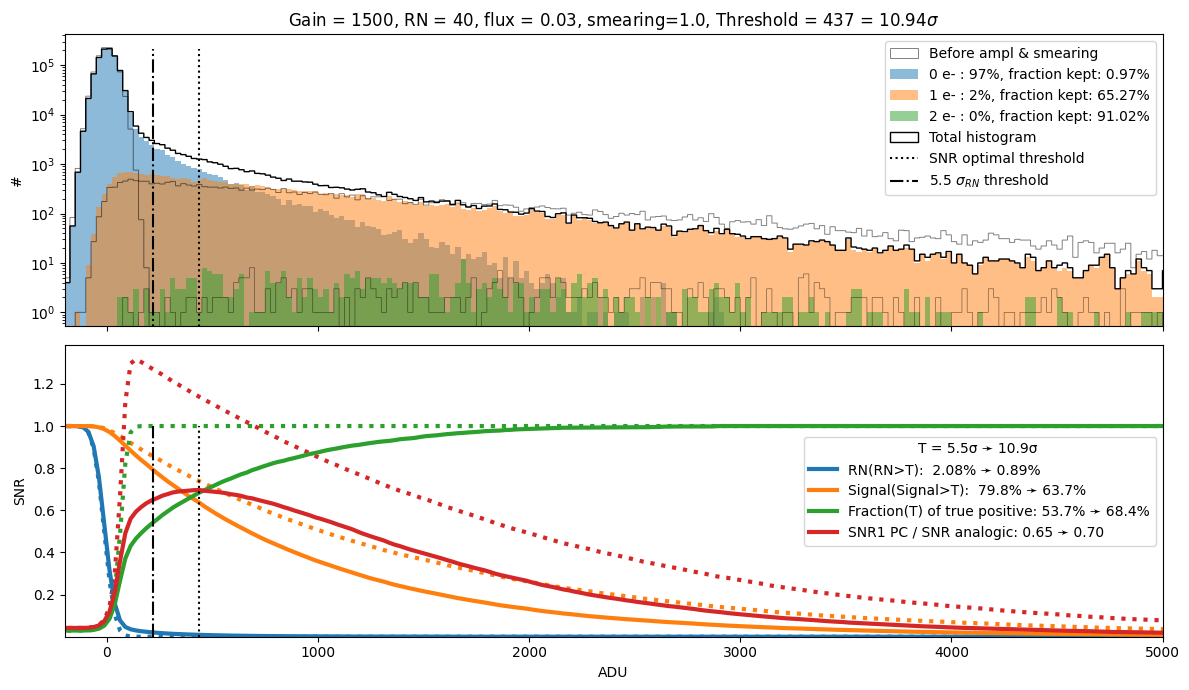

(10.9375, 0.6527479275406816, 0.009701523303032178, 0.6964831520096771)

In [1]:
# from Observation import *
# Observation(exposure_time=np.linspace(50,1500,50),smearing=1,counting_mode=True,plot_=False).compute_optimal_threshold(plot_=True,flux=0.03,size= (int(1e3),int(1e3)))


# <center>ETC - SNR calculator </center>

### Description
This simple ETC gives the estimated signal-to-noise ratio for an extended source on a resolution element.
The main interests of this tool are its genericity, its easy of use and the plotting options.

Indeed, the ETC works for any spectrograph and anyone can add an instrument or a configuration [here](https://docs.google.com/spreadsheets/d/1Ox0uxEm2TfgzYA6ivkTpU4xrmN5vO5kmnUPdCSt73uU/edit?pli=1#gid=2066284077) to directly use the ETC.

This ETC GUI is extremely useful to provide at a glance not only the main instrument parameters and limitations, but also the tradeoffs, possible optimization and mitigation strategies. 


### Variable


The different variables used which can all be used in the x axis to analyze the impact on SNR are:
- **Source:** flux, sky, source extension, source's line width
- **Observing strategy:** Exposure time, total acquisition time, atmospheric transmission, observed wavelength, distance to source/line center
- **Instrument design:** collecting area, plate scale, instrument throughput, spatial resolution (at the mask and at the detector)
- **Spectrograph design:** spectral resolution, slit width, dispersion
- **Detector parameters:** quantum efficiency, dark current, read noise, readout time, pixel size, image loss due to cosmic ray
- **emCCD additional parameters:** EM gain, CIC, thresholding, smearing exponential length and temperature if you check it (based on a first rough evolution of smearing and dark current with temperature, therefore changing the temperature will change smearing and dark accordingly.)

The ETC is designed to provide direct visualization of these budgets with respect to these different variable that could then be tuned/mitigated to improve the instrument sensitivity

### Outputs
In the top panel, the noise of the different sources (Signal, Dark, Sky, CIC, RN) is given in e- per resolution element per N frames on the total acquisition time. The middle panel we give the average e-/pix value for each component (before stacking). We give the relative fraction of all sources of noise and the resulting SNR. 



# <center>Contributions calculations in Electrons per pixel </center>

### Sky and signal
The sky and signal contributions are first converted from $ergs/cm^2/s/asec^2/Å$ to photons/cm $^2$/s/sr/Å (continuum unit): $CU =   \frac{Flux}{\frac{h c}{ \lambda} \times \frac{\pi}{ 180 \times 3600}^2 }$

Note the wavelength dependancy in the formula. 
We decide deliberately to use flux per Angstrom with a gaussian profile so that the user can simulate both a continuum or an unresolved line. 
It will also allow in the future to directly upload a spectra in  $ergs/cm^2/s/asec^2/Å$.

Then, both contributions are converted similarly into electrons per pixels:





$Sky_{e-/pix/exp} = Sky_{CU} \times Slitwidth_{str}  \times Dispersion_{Å/pix}  \times Texp_s \times Atm_\%\times  Area_\% \times Throughput_\%  \times QE_\%  $ 

$Signal_{e-/pix/exp} = Signal_{CU} \times Slitwidth_{str}  \times Dispersion_{Å/pix} \times Texp_s \times Atm_\%\times  Area_\% \times Throughput_\%  \times QE_\%  $

<!-- If the instrument is an imager (no slit and no dispersion), we replace the factor $ Slitwidth_{str}  \times Dispersion_{Å/pix}$ by $FOV_{str} \times Bandwidth_{Å} $. -->

### Other contributions

Other contributions (dark current, read-noise, CIC, straylight) are easier to account for.
Dark and straylight are used with the same unit: $e-/pix/hour$. Therefore:

$Dark_{e-/pix/exp} = Dark_{e-/pix/hour} \times \frac{ Texp_s }{3600}$

CIC (Clock induced charges) which are charges induced in electron amplified CCD, are already given in e-/pix/exp.
Read noise is usually also given in e-/pix/exp.

# <center>Conversion to noise </center>


Each contribution is then converted to noise by taking the square root of the contribution and accounting for the effective number of frames and the element resolution size: 

$N_{Contribution} = \sqrt{Contribution [\times ENF] \times N_{images} \times Size_{resolution element} }$

The number of effective images is:

$N_{images} = \frac{Ttot_s}{Texp_s + Tread_s} \times (1-CRloss_\%) $


In the case of electron amplified CCDs, some considerations must be taken into account:
- the read noise must be divided by the amplification gain: $RN_{e-/pix/exp} = \frac{ RN_{e-/pix/exp} }{EMGain_{e-/e-}}$
- an excess noise factor of $\sqrt{2}$  must be used to account for the stochastic amplification (if no thresholding method is applied)




<!-- Other considerations taken into account:
- cosmic ray loss directly impacting the number of images 
- Taking into account line width
- Taking into account cut my the slit
- 

When doing some photon-counting emCCD thresholding, some new considerations must be added:
- Only part of the charges are accounted for
- When thresholding is applied, the smearing can be changed as it will impact the position of the threshold that optimizes the SNR. For this optimal threshold, the fraction of signal and readnoise kept (above the threshold) is given.
-  -->










<!-- - **Caution:**  it appears that for EMCCDs the dependencies are pretty complex/non-linear. In particular, the lack of models on the impact of amplification, thresholding, and register clearing... combined with smearing on the final SNR makes risky the fact of relying only on modeling to choose the optimal temperature/gain/etc. That's why I suggest an [end-to-end test](https://docs.google.com/document/d/1SpiEK8MBmYduKUFvWmnTOfkfsX4VWs6JMF5-YJKDELo/edit?usp=sharing) validating this:  -->




<!-- 
### Need to add
- Predictions for point source, sources on several resolution element, stack of galaxies
 -->

<!-- Based on the 2019 and 2022 images the consequences of a 20 degrees increase is important. With the first approximations, the increase of the dark current combined with the decrease of the smearing length might lead to a 5% SNR increase in counting mode (+sharper PSF). Though, for now, the major consequence of the temperature increase seems to be the high fraction of cosmetics on the lower part of the image. A significant fraction could be corrected for with appropriated software but the fraction can become extremely high and prevent good correction (needs further implementation). This is not taken into account in this model. Decreasing the tempetrature to -100C (TBD) might be a good trade off (in 2019 we had 0.8 smearing at -95C and EMgain=1600). For very bright objects the shot noise becomes dominant and then the impact of dark current is smaller so the SNR peaks at higher temps (80).
 -->


<!-- # Sky background
Sky background is given in line unit (LU= 1 ph/cm $^2$/s/sr).
To convert surface brightness $ergs/cm^2/s/asec^2$ Lto LU one can follow:
$$LU =   \frac{Flux[ergs/cm^2/s/asec^2]}{\frac{h c}{ \lambda} \times \frac{\pi}{ 180 \times 3600}^2 }   $$




The total sky background when stacking along the dispersion direction:
$$F[e-/pix/s] = Sky_{LU} \times Atm\times  Area_{telescope}[cm^2] \times Throughput  \times QE \times   Area_{pix} [Str] $$
The sky background per pixel:
$$F[e-/pix/s] = \frac{Sky_{LU} \times Size_{pix}[Å] }{\lambda_{range}} \times Atm\times  Area_{telescope}[cm^2] \times Throughput  \times QE \times   Area_{pix} [Str] $$
For FIREBall, we have assumed a total sky background (extragalactic + atmospheric) of 500 continuum units [$ph /s/cm^2 /sr /Å = LU/Å$]
 -->

<!-- 

### FIREBall analysis
To confirm the re-flight readiness of the FIREBall-2 instrument, these updated parameters were used to design a FB-specific ETC. This ETC aims at exploring the ultimate efficiency the instrument could reach in nominal flight conditions or after mitigation, and check its evolution under different scenarios. While this ETC is fairly simple and could be easily adapted to different projects, it includes several FB-related specificities that can have a dramatic impact on the final sensitivity (cosmic-ray-related surface loss, 40km-altitude sky-background, CTE, amplification model, optimal threshold computation and efficiency, flux cut by the slit, etc.). In addition, [post-]flight EMCCD data were analyzed in detail to understand the complexity and potential of these devices. 

The main interest of such devices is the ability, due to ~1000 stochastic amplifications of the incoming electrons and under certain conditions, to detect single photo-electrons. The amplification generates an excess noise factor that can be removed by post-processing (e.g.: thresholding photon-counting [5]). Unfortunately, this method is efficient under conditions that are difficult to reach at our temperature levels as read noise and smearing conspire against its efficient use.


One outcome of this work was the development of an EMCCD model to analyze the detector performance. Compared to the Poisson-Gamma-Normal EMCCD likelihood model developed [5], the addition of smearing in the model allowed us to reproduce all the detector data histograms and infer automatically the associated parameters (read noise, amplification gain, smearing, serial and semi-amplified clock-induced charges (CIC), flux) making it an extremely powerful tool (see Fig. 3). This smearing-included EMCCD model is more realistic and was incorporated into the ETC to automatically compute the photon-counting threshold that optimizes the SNR based on different parameters. The full ETC, shown in Fig. 4, and available at https://fireball-etc.lam.fr, shows the budget from the different contributors to a frame (signal, sky background, dark current, CIC, guider-related background, read noise), as well as the noise budget and the final SNR on a FB-flight-like science acquisition and the limiting flux for point-like and diffuse sources. The ETC is designed to provide direct visualization of these budgets with respect to the different flight/detector parameters that can be tuned and/or mitigated, namely:
- Mission parameters: acquisition time, PSF size at the mask and detector level, thresholding (or not), sky background, exposure time, readout time.
- EMCCD parameters: amplification gain, device temperature (determining dark current and CTE), read noise, CIC, CR rate or induced loss

This ETC GUI is extremely useful to provide at a glance not only the main instrument parameters and limitations, but also the tradeoffs, possible optimization and mitigation strategies. For example, it confirms the sensitivity limit measured on the 2018 flight data and predicts an important 30-40 gain factor on the limiting fluxes after mitigation of the sky and guider-related backgrounds, and a better image quality (on a nominal acquisition time: 2h). The different subplots provide the remaining major offenders of the instrument. A simple click-change of the x-axis allows one to detect changes of parameters that most affect the final SNR and which enables grading correction and tolerancing. After these first-order analyses, the ETC allows one to further analyze/optimize other subtle tradeoffs (The full complexity of these tradeoffs can not be totally encompassed by an ETC as it would require adding a risk component, uncertainty, tolerancing, the preference for smooth low-risk optimums than higher but sharper SNR: for instance the loss of pointing if we add a shutter during a longer readout time, the interest of having data usable with and without thresholding, temperature-induced complexities such as condensation, the possible improvement of smearing inversion algorithms, etc.) :


- Exposure time: this tradeoff (as shown in Fig. 4) results from an important read noise contribution at short exposure times, important surface loss due to the ~10/sec CR impact rate for long exposures, and the photon counting thresholding efficiency that decreases significantly when the number of electrons per pixel per exposure gets too high/low.
- Detector temperature: while dark current increases exponentially with temperature, charge transfer gets less and less efficient as the temperature decreases (below 190 K). The parameterization of the dark current and CTE temperature dependency allows one to derive the optimal temperature tradeoff.
- Readout frequency: the new version of the EMCCD controller enables reading out the image at 1 MHz instead of 10 MHz. Although this slower rate can decrease the read noise by a factor of 2 and might improve the CTE, it also increases the readout time by a factor of 5 to 10 (which might require the use of a shutter during image reading). At our temperature, the use of the 1 MHz readout appears to increase the overall SNR.
- Photon counting threshold: the threshold used to hamper the excess noise factor in EMCCDs (only possible under strict conditions) depends significantly on different parameters. While a low threshold will increase the false event rate, a high threshold will generate a significant loss of signal, hence removing the thresholding efficiency and interest. The optimum SNR(threshold) and its shape depend mostly on the effective amplification gain (significantly impacted by smearing) to read-noise ratio that needs to stay >>10 in order to be efficient but is also impacted by the input flux and the other noise sources. -->


In [17]:
# instruments_dict={}
# for inst in instruments.colnames[1:]:
#     instruments_dict = +{inst:{key:val for key, val in zip(instruments["Charact."],instruments[inst])}} 

# instruments_dict

TypeError: bad operand type for unary +: 'dict'

In [2]:
# values = [instrument]+[ instruments[instrument][instruments["Charact."]==field][0] for field in ["FOV","wavelength","Throughput","Atmosphere","pixel_scale","area"]]
# f'Instrument=1'+ f'FOV=%s, λ=%iÅ, Throughput=%i%%, Atm=%i%%, Platescale=%.1f, area=%icm2'%(*[ float(instruments[instrument][instruments["Charact."]==field][0]) for field in ["FOV size","wavelength","Throughput","Atmosphere","pixel_scale","area"]])
# # tab = Table.from_pandas(instruments)
# # instrument = "FIREBall-2"
# # for i in range(len(tab)):
# #     print(tab["Charact."][i], tab[instrument][i])

In [11]:
# a=Table(names=["Charact."] + [key for key in instruments.keys()],dtype=[str]*(len(instruments)+1))

# for key in instruments["FIREBall-2"].keys():
#     row = [key] + [str(instruments[keyi][key]) for keyi in instruments.keys()]
#     print(row)
#     a.add_row(row)
#     # for keyi in instruments.keys():
# a.write("/Users/Vincent/Github/fireball2-etc/instruments.csv")
# # ={"FIREBall-2":FIREBall,"CHaS":CHaS,"KCWI-red":KCWI_red,"KCWI-blue":KCWI_blue,"FIREBall-2 2018":FIREBall_2018}


<!-- # <center>ETC - SNR calculator </center>

### Explanation
- Gives the estimated signal-to-noise ratio for an extended source on a resolution element
- **Variables:** Source's flux, sky, acquisition time, exposure time, EM gain, dark current, CIC, read noise, readout time, thresholding, smearing exponential length and temperature if you check it (based on a first rough evolution of smearing and dark current with temperature, therefore changing the temperature will change smearing and dark accordingly.)
- **Fixed Values:** QE = 45%, resolution element=57 mu, pixel_size = 13 mu, throughput = 13%, atmosphere transmission = 50%
- **Outputs:** In the top panel, the noise of the different sources (Signal, Dark, Sky, CIC, RN) is given in e- per resolution element per N frames on the total acquisition time. The middle panel we give the average e-/pix value for each component (before stacking). We give the relative fraction of all sources of noise and the resulting SNR. When thresholding is applied, the smearing can be changed as it will impact the position of the threshold that optimizes the SNR. For this optimal threshold, the fraction of signal and readnoise kept (above the threshold) is given.
<!-- - **Caution:**  it appears that for EMCCDs the dependencies are pretty complex/non-linear. In particular, the lack of models on the impact of amplification, thresholding, and register clearing... combined with smearing on the final SNR makes risky the fact of relying only on modeling to choose the optimal temperature/gain/etc. That's why I suggest an [end-to-end test](https://docs.google.com/document/d/1SpiEK8MBmYduKUFvWmnTOfkfsX4VWs6JMF5-YJKDELo/edit?usp=sharing) validating this:  -->




<!-- 
### Need to add
- Predictions for point source, sources on several resolution element, stack of galaxies
 -->

<!-- Based on the 2019 and 2022 images the consequences of a 20 degrees increase is important. With the first approximations, the increase of the dark current combined with the decrease of the smearing length might lead to a 5% SNR increase in counting mode (+sharper PSF). Though, for now, the major consequence of the temperature increase seems to be the high fraction of cosmetics on the lower part of the image. A significant fraction could be corrected for with appropriated software but the fraction can become extremely high and prevent good correction (needs further implementation). This is not taken into account in this model. Decreasing the tempetrature to -100C (TBD) might be a good trade off (in 2019 we had 0.8 smearing at -95C and EMgain=1600). For very bright objects the shot noise becomes dominant and then the impact of dark current is smaller so the SNR peaks at higher temps (80).
 --> 

<!-- # Sky background
Sky background is given in line unit (LU= 1 ph/cm $^2$/s/sr).
To convert surface brightness $ergs/cm^2/s/asec^2$ Lto LU one can follow:
$$LU =   \frac{Flux[ergs/cm^2/s/asec^2]}{\frac{h c}{ \lambda} \times \frac{\pi}{ 180 \times 3600}^2 }   $$




The total sky background when stacking along the dispersion direction:
$$F[e-/pix/s] = Sky_{LU} \times Atm\times  Area_{telescope}[cm^2] \times Throughput  \times QE \times   Area_{pix} [Str] $$
The sky background per pixel:
$$F[e-/pix/s] = \frac{Sky_{LU} \times Size_{pix}[\AA] }{\lambda_{range}} \times Atm\times  Area_{telescope}[cm^2] \times Throughput  \times QE \times   Area_{pix} [Str] $$
For FIREBall, we have assumed a total sky background (extragalactic + atmospheric) of 500 continuum units [$ph /s/cm^2 /sr /\AA = LU/\AA$]
 -->


<!-- 
## Thresholding analysis
The threshold is computed by optimizing the SNR:

$$ SNR_1(T) = F_{True,pos}(T)\frac{S \times F_{e^->0,ADU>T}}{\sqrt{ F_{e^->0,ADU>T} \times(S + \sigma_{CIC}^2 + \sigma_{DC}^2+ \sigma_{SKY}^2)  + F_{e^-=0,ADU>T} \frac{\sigma_{RN}^2}{Gain} }} 
\sim F_{True,pos}(T) \frac{S \sqrt{ F_{e^->0,ADU>T}}}{\sqrt{S + \sigma_{CIC}^2 + \sigma_{DC}^2+ \sigma_{SKY}^2 }}$$



with:
- $\sigma_{RN}^2=\frac{RN}{G_{EM}} \times \frac{\sum RN[RN>T]}{\sum RN} = \frac{RN}{EMgain}  \times \%pix_{e^-=0}^{ADU>T}$: ie 60e-/2000 x the fraction of pixels above the threshold which dit not receive any photo-electrons
- $ F_{e^->0,ADU>T}$ :  fraction of pixels above the threshold which received more than 0 electons
- $ F_{e^-=0,ADU>T}$ :  fraction of pixels above the threshold which did not receive any electron
- $F_{True,pos} = \frac{F_{e^->0,ADU>T}}{F_{ADU>T}} $ : the fraction of true positives = the fraction of pixels above the threshold which received more than 0 electons. This uncertainty term is not in the final SNR formula as it converges towards ~1 after stacking as the average pixel value will converge towards the real number of incoming photo-electrons


The thresholding depends on 5 factors:
- **The gain**: the higher the gain the easier it is to differentiate pixels who received a photo-electron and those which did not
- **The read noise**: the lower the RN the easier it is to differentiate pixels who received a photo-electron and those which did not
- **The low CTE** smears the charges, from pixels who did receive a photo-electron to pixel who did not and lower the effective gain $G_{EM,eff}$
- **The signal**: because thresholding only allows to recover 0 and 1, thresholding is only efficient at flux <<1e-/exp 
- **The additional noise**: $\sigma = \sigma_{CIC}^2 + \sigma_{DC}^2+ \sigma_{SKY}^2$ has relatively small impact on the impact of the thresholding

**At the end, the thresholding impact is:**
- Highly non linear, many things to learn
- The efficiency of the thresholding depends mostly of the ratio $\frac{G_{EM,eff}}{RN}$, which extremely impacted by the smearing.
- The thresholding SNR gain ($SNR_{threshold}$ /$SNR_{analogic}$) lies within $[0,\sqrt{2}]$. Condditions are pretty stricts to get som thresholding efficiency and smearing makes the upper bound falls dramatically. 
- Therefore if might not worth it to loose SNR in order to be in these very conditions as we will loose it anyway in the final budget.
- The thresholding SNR gain seems less impacted by read noise. Which means that if we manage to do some (linear?) inversion of the smearing which increases the noise, it might still increase the thresholding gain above 1. 
- The only real game changer in terms of SNR is the smearing 
- **Fraction kept (photo-electrons above threshold)**
    - Important dependance on smearing and flux, less important one on gain and read noise.
    - At low smearing the bigger the ratio gain/ron the higher the fraction of charges kept.
    - Evolution with smearing is dramatic, higher gain does not help much, lower RN helps
    - Fraction increase with flux 
- **Fraction fake detections (0e- pixels above threshold)**
    - Increases importantly with smearing
    - does not depend much on read noise (small positive correlation)
    - decreases with gain
    - Increases as Flux increase. Not sure to understand why... Maybe because the number of pixels with 0 photo-e- cecreases 
- **Thresholding SNR gain**
    - Thresholding is efficient only if >1
    - Dramatically decreases with smearing (No interest of thrsholding above smearing legth of 0.6)
    - Increases with gain and decreases with read noise if no smearing
    - if smearing, the read noise has no impact.
    - Increases with flux
- **Threshold**
    - increase extremely with smearing
    - Without smearing, poor dependance on gain and readnoise
    - If smearing, increases as readnoise decreases
    - If smearing: Increasing with gain!
    - Increases with flux




|   **Thresholding dependancy table**                   | **Smearing <br />  ( 0 - 2 )** | **Read noise  <br /> ( 30 - 120 )** | **Gain  <br /> ( 800 - 2500 )** | **Flux <br /> ( 0.01 - 1.5 )** |
|:--------------------:|:------------------:|:-----------------------:|:-------------------:|:------------------:|
|     **Photo-electron Fraction kept**    |    --- <br /> 92% - 66%    |       -  <br /> 72% - 71%       |     .   <br /> 72% - 71%    |     +  <br /> 75% - 76%    |
| **RN fraction kept** |  +++  <br /> 0.6% - 12.4%  |       +  <br /> 0.7% - 1%       |    -  <br /> 1.1% - 0.5%    |    ++?  <br /> 0.3% - 3%   |
|     **Threshold**    |   +++  <br /> 3 σ - 11 σ   |      --  <br /> 18 σ - 5 σ      |     + <br />  5 σ - 16 σ    |    +? <br />  8 σ - 13 σ    |
|        **Thresholding SNR gain**       |     --- <br />  1.3 - 0.6   |        --  <br /> 1.35 - 1.22        |      +  <br /> 1.13 - 1.18      |      ++  <br /> 1.16 - 1.21     |
 -->


<!-- # <center>FIREBall-2 SNR calculator </center>

### Explanation
- Gives the estimated signal-to-noise ratio for an extended source on a resolution element
- **Variables:** Source's flux, sky, aquisition time, exposure time, EM gain, dark current, CIC, readnoise, readout time, thresholding, smearing exponential length and temperature if you check it (based on a first rough evolution of smearing and dark current with temperature, therefore changing the temperature will change smearing and dark accordingly.)
- **Fixed Values:** QE = 45%, resolution element=57 mu, pixel_size = 13 mu, throughput = 13%, atmosphere transmission = 50%
- **Outputs:** In the top pannel, the noise of the different sources (Signal, Dark, Sky, CIC, RN) is given in e- per resolution element per N frames on the total acquisition time. The middle pannel we give the average e-/pix value for each component (before stacking). We give the relative fraction of all sources of noise and the resulting SNR. When thresholding is applied, the smearing can be changed as it will impact the position of the threshold that optimizes the SNR. For this optimal threshold, the fraction of signal and readnoise kept (above the threshold) is given.
- **Caution:**  it appears that for EMCCDs the dependencies are pretty complex/non-linear. In particular, the lack of models on the impact of amplification, thresholding, and register clearing... combined with smearing on the final SNR makes risky the fact of relying only on modeling to choose the optimal temperature/gain/etc. That's why I suggest an [end-to-end test](https://docs.google.com/document/d/1SpiEK8MBmYduKUFvWmnTOfkfsX4VWs6JMF5-YJKDELo/edit?usp=sharing) validating this: 


### Analysis
- **Smearing:** At -120C, the low device's CTE smears the pixels' counts and then lowers the effective gain. This lowering factor is huge (>2) for a smearing length of 1.5, but is much smaller for a smearing length of 0.7 (~1.2). 
It seems that we already had a comparabale 0.7 smearing length with previous controller at 10MHz (tests February 7th and 8th 2019) at same EMgain (1600) and temperature (-95C). Which might mean that the 1MHz reading does not decrease significantly the smearing. **With the current (2022) smearing length, thresholding does not increase the SNR!! If we manage to invert the smearing, even if it doubles the readnoise, we could recover most of the thresholding efficiency.**
- **Photon-counting:** The thresholding effect can be misleading as it depends on Flux, EMgain, RN, smearing and noise($\sigma_{CIC}^2 + \sigma_{DC}^2+ \sigma_{SKY}^2$). But actually it depends mostly on the ratio $\frac{G_{EM,eff}}{RN}$. For a ratio >> 10 the thresholding is efficient. As stated above for a smearing length of 0.7, EMgain and effective_gain are close. A consequence of that, is that at the EMgains we use ($\sim1600$) and smearing $\sim 0.7$, the thresholding is almost as efficient with RN=50 and RN=107 as the ratio $\frac{G_{EM,eff}}{RN}$ stays >>10. This was not the case in 2018 when the smearing length was 1.5. This is why in photon counting mode, you will see a very small impact of read noise change.
- **Reading frequency tradeoff:** Based on above, the change from 10MHz to 1MHz as minor consequences on the total SNR.
    - In photon counting mode and with low smearing, the decrease of the RN has quasi no effect (~1%) on the SNR
    - The transition from 1.4 to 3sec readout would mean a loss of SNR of ~2%, transition to 10sec about ~10% 
    - Therefore the real critical point is the possible need to add or not a shutter above the tank with the 1MHz controller as it will complexify guidance
- **Temperature Tradeoff:** Conclusion depends on the definition of SNR on thresholded images (see below): In both cases, the SNR decreases with smearing but in one case smearing has more important impact and compensate  dark current giving rise to an optimal temperature. Though, the fact that we will never get rid of dark current while we could actually manage to inverse the smearing could suggest staying at low temperature (-120 to -110).

 
  
  
|             **Parameters**             |          **2022 1Mhz controller**           | **Values 2018** |
| :------------------------------------: | :-----------------------------------------: | :-------------: |
|          **Temperature (C)**           |                     -95                     |      -115       |
|       **Conversion gain ADU/e-**       |                    1/4.5                    |      0.53       |
|           **Read noise e-**            |            50 -> 60 longer cable            |       107       |
|         **pCIC e− /pix/frame**         |                    0.003                    |      0.004      |
|         **sCIC e− /pix/frame**         |                   ~0.002                    |     ~0.002      |
|  **semi-amplified CIC e− /pix/frame**  |                    ~0.02                    |     ~0.03-4     |
|           **EM gain  e-/e-**           |          O                    2000          |      1400       |
|   **Smearing exponent. length pix**    |              L~0.6 ± 0.1  pix               |   L~1.5 ± 0.1   |
|       **Dark current e− /pix/h**       |                   ~2±0.5                    |   0.5 ± 0.03    |
| **Cosmetics % pixels bottom detector** |                     ~2%                     |   <<1% (TBD)    |
|         **Exposure time sec**          |                     50                      |       50        |
|          **Readout time sec**          | ~10 (all), ~3(physical) +2 better clearance |      ~1.4       |


<!-- 
### Need to add
- Predictions for point source, sources on several resolution element, stack of galaxies
 -->

<!-- Based on the 2019 and 2022 images the consequences of a 20 degrees increase is important. With the first approximations, the increase of the dark current combined with the decrease of the smearing length might lead to a 5% SNR increase in counting mode (+sharper PSF). Though, for now, the major consequence of the temperature increase seems to be the high fraction of cosmetics on the lower part of the image. A significant fraction could be corrected for with appropriated software but the fraction can become extremely high and prevent good correction (needs further implementation). This is not taken into account in this model. Decreasing the tempetrature to -100C (TBD) might be a good trade off (in 2019 we had 0.8 smearing at -95C and EMgain=1600). For very bright objects the shot noise becomes dominant and then the impact of dark current is smaller so the SNR peaks at higher temps (80).
 --> 

<!-- 
## Thresholding analysis
The threshold is computed by optimizing the SNR:

$$ SNR_1(T) = F_{True,pos}(T)\frac{S \times F_{e^->0,ADU>T}}{\sqrt{ F_{e^->0,ADU>T} \times(S + \sigma_{CIC}^2 + \sigma_{DC}^2+ \sigma_{SKY}^2)  + F_{e^-=0,ADU>T} \frac{\sigma_{RN}^2}{Gain} }} 
\sim F_{True,pos}(T) \frac{S \sqrt{ F_{e^->0,ADU>T}}}{\sqrt{S + \sigma_{CIC}^2 + \sigma_{DC}^2+ \sigma_{SKY}^2 }}$$



with:
- $\sigma_{RN}^2=\frac{RN}{G_{EM}} \times \frac{\sum RN[RN>T]}{\sum RN} = \frac{RN}{EMgain}  \times \%pix_{e^-=0}^{ADU>T}$: ie 60e-/2000 x the fraction of pixels above the threshold which dit not receive any photo-electrons 
- $ F_{e^->0,ADU>T}$ :  fraction of pixels above the threshold which received more than 0 electons
- $ F_{e^-=0,ADU>T}$ :  fraction of pixels above the threshold which did not receive any electron
- $F_{True,pos} = \frac{F_{e^->0,ADU>T}}{F_{ADU>T}} $ : the fraction of true positives = the fraction of pixels above the threshold which received more than 0 electons. This uncertainty term is not in the final SNR formula as it converges towards ~1 after stacking as the average pixel value will converge towards the real number of incoming photo-electrons

The thresholding depends on 5 factors:
- **The gain**: the higher the gain the easier it is to differentiate pixels who received a photo-electron and those which did not
- **The read noise**: the lower the RN the easier it is to differentiate pixels who received a photo-electron and those which did not
- **The low CTE** smears the charges, from pixels who did receive a photo-electron to pixel who did not and lower the effective gain $G_{EM,eff}$
- **The signal**: because thresholding only allows to recover 0 and 1, thresholding is only efficient at flux <<1e-/exp 
- **The additional noise**: $\sigma = \sigma_{CIC}^2 + \sigma_{DC}^2+ \sigma_{SKY}^2$ has relatively small impact on the impact of the thresholding

**At the end, the thresholding impact is:**
- Highly non linear, many things to learn
- The efficiency of the thresholding depends mostly of the ratio $\frac{G_{EM,eff}}{RN}$, which extremely impacted by the smearing.
- The thresholding SNR gain (SNR$_{threshold}$/SNR$_{analogic}$) lies within $[0,\sqrt{2}]$. Condditions are pretty stricts to get som thresholding efficiency and smearing makes the upper bound falls dramatically. 
- Therefore if might not worth it to loose SNR in order to be in these very conditions as we will loose it anyway in the final budget.
- The thresholding SNR gain seems less impacted by read noise. Which means that if we manage to do some (linear?) inversion of the smearing which increases the noise, it might still increase the thresholding gain above 1. 
- The only real game changer in terms of SNR is the smearing 
- **Fraction kept (photo-electrons above threshold)**
    - Important dependance on smearing and flux, less important one on gain and read noise.
    - At low smearing the bigger the ratio gain/ron the higher the fraction of charges kept.
    - Evolution with smearing is dramatic, higher gain does not help much, lower RN helps
    - Fraction increase with flux 
- **Fraction fake detections (0e- pixels above threshold)**
    - Increases importantly with smearing
    - does not depend much on read noise (small positive correlation)
    - decreases with gain
    - Increases as Flux increase. Not sure to understand why... Maybe because the number of pixels with 0 photo-e- cecreases 
- **Thresholding SNR gain**
    - Thresholding is efficient only if >1
    - Dramatically decreases with smearing (No interest of thrsholding above smearing legth of 0.6)
    - Increases with gain and decreases with read noise if no smearing
    - if smearing, the read noise has no impact.
    - Increases with flux
- **Threshold**
    - increase extremely with smearing
    - Without smearing, poor dependance on gain and readnoise
    - If smearing, increases as readnoise decreases
    - If smearing: Increasing with gain!
    - Increases with flux

 -->

<!-- 

|   **Thresholding dependancy table**                   | **Smearing <br />  ( 0 - 2 )** | **Read noise  <br /> ( 30 - 120 )** | **Gain  <br /> ( 800 - 2500 )** | **Flux <br /> ( 0.01 - 1.5 )** |
|:--------------------:|:------------------:|:-----------------------:|:-------------------:|:------------------:|
|     **Photo-electron Fraction kept**    |    --- <br /> 92% - 66%    |       -  <br /> 72% - 71%       |     .   <br /> 72% - 71%    |     +  <br /> 75% - 76%    |
| **RN fraction kept** |  +++  <br /> 0.6% - 12.4%  |       +  <br /> 0.7% - 1%       |    -  <br /> 1.1% - 0.5%    |    ++?  <br /> 0.3% - 3%   |
|     **Threshold**    |   +++  <br /> 3 σ - 11 σ   |      --  <br /> 18 σ - 5 σ      |     + <br />  5 σ - 16 σ    |    +? <br />  8 σ - 13 σ    |
|        **Thresholding SNR gain**       |     --- <br />  1.3 - 0.6   |        --  <br /> 1.35 - 1.22        |      +  <br /> 1.13 - 1.18      |      ++  <br /> 1.16 - 1.21     |
 -->
